# Cinema Audience Forecasting Challenge

**Objective**: Predict cinema audience count for future dates based on historical data

# 1. Data Loading

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

Load CSVs into DataFrames


In [2]:
movie_theater_id_relation = pd.read_csv("movie_theater_id_relation.csv")
date_info = pd.read_csv("date_info.csv")
sample_submission = pd.read_csv("sample_submission.csv")
booknow_theaters = pd.read_csv("booknow_theaters.csv")
cinePOS_booking = pd.read_csv("cinePOS_booking.csv")
cinePOS_theaters = pd.read_csv("cinePOS_theaters.csv")
booknow_visits = pd.read_csv("booknow_visits.csv")
booknow_booking = pd.read_csv("booknow_booking.csv")

# 2. Exploratry Data Analysis


## 2.1 Quick Exploration

In [3]:
# Quick check of shapes
print("movie_theater_id_relation:", movie_theater_id_relation.shape)
print("date_info:", date_info.shape)
print("sample_submission:", sample_submission.shape)
print("booknow_theaters:", booknow_theaters.shape)
print("cinePOS_booking:", cinePOS_booking.shape)
print("cinePOS_theaters:", cinePOS_theaters.shape)
print("booknow_visits:", booknow_visits.shape)
print("booknow_booking:", booknow_booking.shape)

movie_theater_id_relation: (150, 2)
date_info: (547, 2)
sample_submission: (38062, 2)
booknow_theaters: (829, 5)
cinePOS_booking: (1641966, 4)
cinePOS_theaters: (4690, 5)
booknow_visits: (214046, 3)
booknow_booking: (68336, 4)


In [4]:
movie_theater_id_relation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_theater_id  150 non-null    object
 1   cine_theater_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [5]:
date_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_date    547 non-null    object
 1   day_of_week  547 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB


In [6]:
booknow_theaters.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_theater_id  314 non-null    object 
 1   theater_type     829 non-null    object 
 2   theater_area     829 non-null    object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [7]:
cinePOS_booking.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   cine_theater_id   1641966 non-null  object
 1   show_datetime     1641966 non-null  object
 2   booking_datetime  1641966 non-null  object
 3   tickets_sold      1641966 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 50.1+ MB


In [8]:
cinePOS_theaters.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [9]:
booknow_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [10]:
booknow_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_theater_id   68336 non-null  object
 1   show_datetime     68336 non-null  object
 2   booking_datetime  68336 non-null  object
 3   tickets_booked    68336 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              38062 non-null  object
 1   audience_count  38062 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 594.8+ KB


In [12]:
def analyze_data_quality(df, name):
    total_records = len(df)
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / total_records * 100).round(2)
    duplicates = df.duplicated().sum()
    
    return {
        'total_records': total_records,
        'missing_data': missing_data.sum(),
        'duplicates': duplicates,
        'completeness': ((total_records * len(df.columns) - missing_data.sum()) / (total_records * len(df.columns)) * 100).round(2)
    }

datasets = {
    'bbooknow_visits': booknow_visits,
    'booknow_booking': booknow_booking, 
    'booknow_theaters': booknow_theaters,
    'cinePOS_booking': cinePOS_booking,
    'cinePOS_theaters': cinePOS_theaters,
    'date_info': date_info,
    'movie_theater_id_relation': movie_theater_id_relation,
    'sample_submission': sample_submission
}

quality_summary = {}
for name, df in datasets.items():
    quality_summary[name] = analyze_data_quality(df, name)

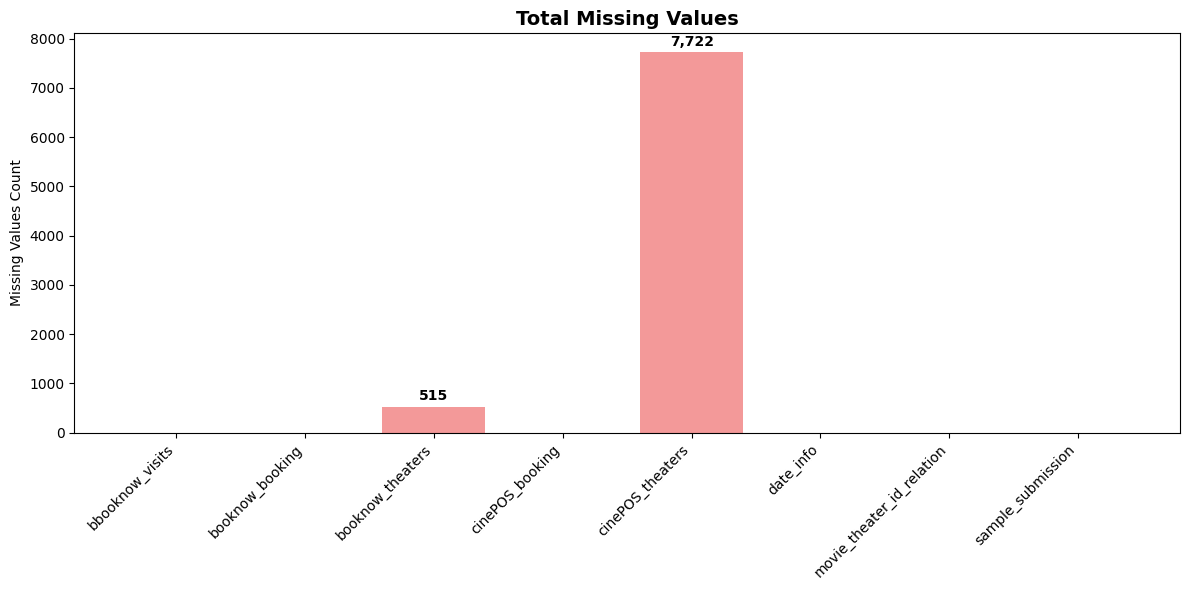

In [13]:
# Missing Data Visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

names = list(quality_summary.keys())
missing_data = [quality_summary[name]['missing_data'] for name in names]
bars = ax.bar(range(len(names)), missing_data, color='lightcoral', alpha=0.8)
ax.set_title('Total Missing Values', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(names)))
ax.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=45, ha='right')
ax.set_ylabel('Missing Values Count')

# Add value labels on bars
for i, v in enumerate(missing_data):
    if v > 0:
        ax.text(i, v + max(missing_data)*0.01, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 2.2 booknow_visits Analysis

In [14]:
booknow_visits.shape

(214046, 3)

In [15]:
booknow_visits.columns

Index(['book_theater_id', 'show_date', 'audience_count'], dtype='object')

In [16]:
booknow_visits['show_date'].min() 


'2023-01-01'

In [17]:
booknow_visits['show_date'].max()

'2024-02-28'

In [18]:
booknow_visits['book_theater_id'].nunique()

826

In [19]:
booknow_visits['audience_count'].sum()

np.int64(8907860)

In [20]:
# AUDIENCE VISITS STATISTICS
theater_performance = booknow_visits.groupby('book_theater_id').agg({'audience_count': ['mean', 'min', 'max', 'std', 'count']}).round(2)
theater_performance.columns = ['avg_audience', 'min_audience', 'max_audience', 'std_audience', 
                                'total_shows']
theater_performance = theater_performance.sort_values('avg_audience', ascending=False)


In [21]:
# Fill the missing std with 0
theater_performance['std_audience'].fillna(0, inplace=True)

In [22]:
theater_performance.isna().sum()

avg_audience    0
min_audience    0
max_audience    0
std_audience    0
total_shows     0
dtype: int64

In [23]:
theater_performance.head(10)

,avg_audience,min_audience,max_audience,std_audience,total_shows
book_theater_id,,,,,
book_00169,127.54,14,218,32.42,197
book_00095,127.13,4,410,82.20,113
book_00152,108.88,4,224,74.46,25
book_00490,105.00,4,170,33.96,182
book_00158,101.11,2,656,62.42,167
book_00589,98.45,34,230,40.82,334
book_00491,94.51,42,144,21.83,79
book_00596,93.48,2,398,86.25,46
book_00292,93.47,4,610,56.15,187


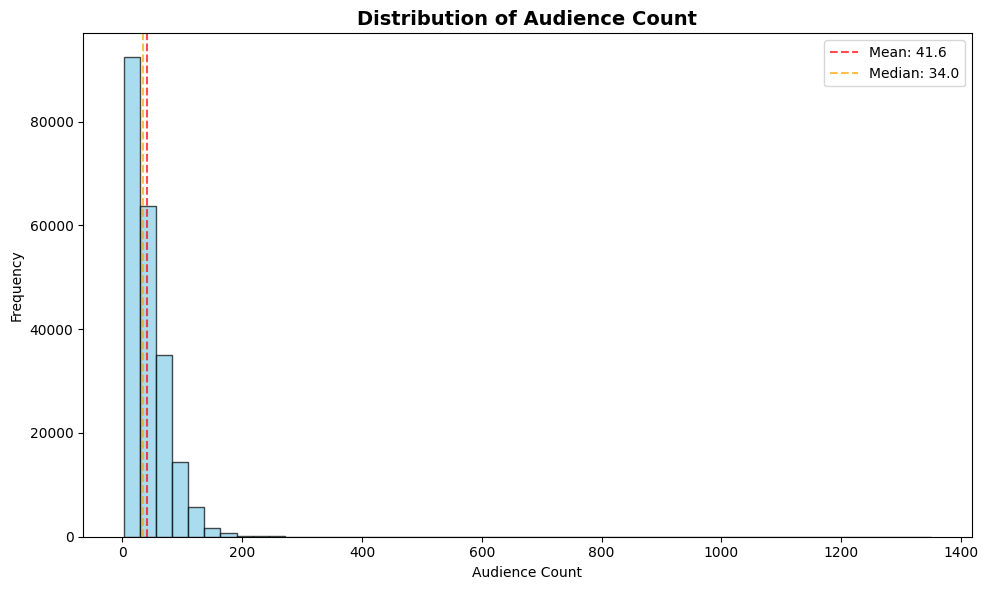

In [24]:
# 1. Audience Count Distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(booknow_visits['audience_count'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
ax.set_title('Distribution of Audience Count', fontsize=14, fontweight='bold')
ax.set_xlabel('Audience Count')
ax.set_ylabel('Frequency')

# Add statistics text
mean_audience = booknow_visits['audience_count'].mean()
median_audience = booknow_visits['audience_count'].median()
ax.axvline(mean_audience, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_audience:.1f}')
ax.axvline(median_audience, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_audience:.1f}')
ax.legend()

plt.tight_layout()
plt.show()

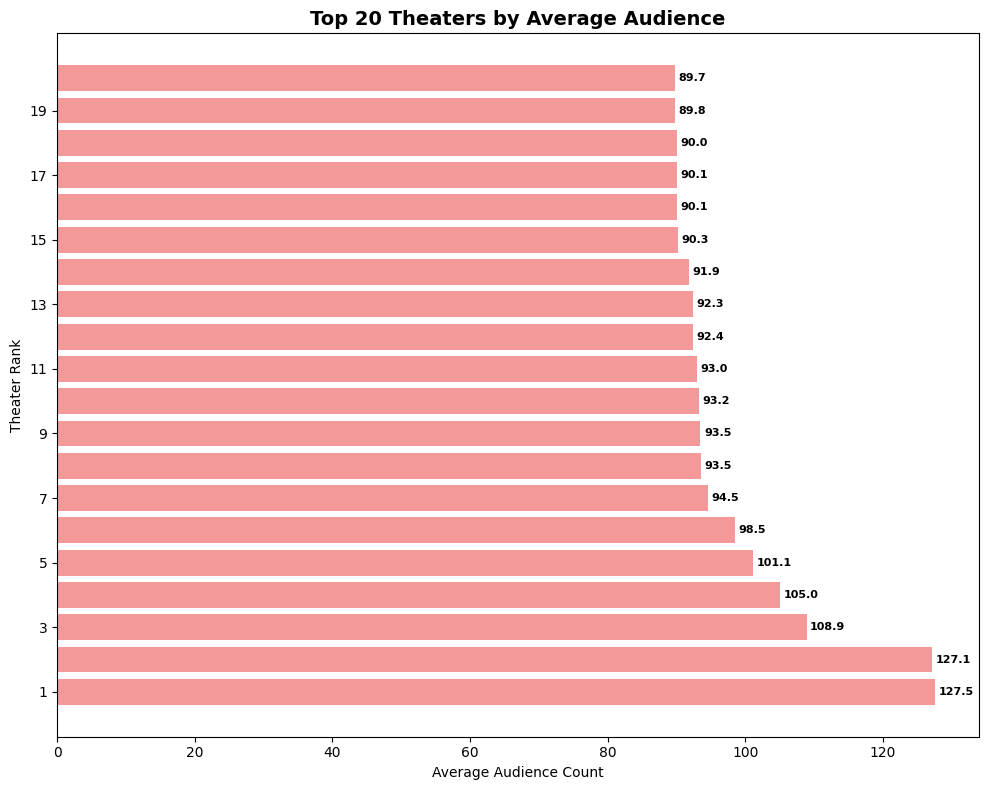

In [25]:
# 2. Top 20 Theaters by Average Audience
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

top_20_theaters = theater_performance.head(20)
bars = ax.barh(range(len(top_20_theaters)), top_20_theaters['avg_audience'], color='lightcoral', alpha=0.8)
ax.set_title('Top 20 Theaters by Average Audience', fontsize=14, fontweight='bold')
ax.set_xlabel('Average Audience Count')
ax.set_ylabel('Theater Rank')
ax.set_yticks(range(0, len(top_20_theaters), 2))
ax.set_yticklabels([f'{i+1}' for i in range(0, len(top_20_theaters), 2)])

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_20_theaters['avg_audience'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{value:.1f}', ha='left', va='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

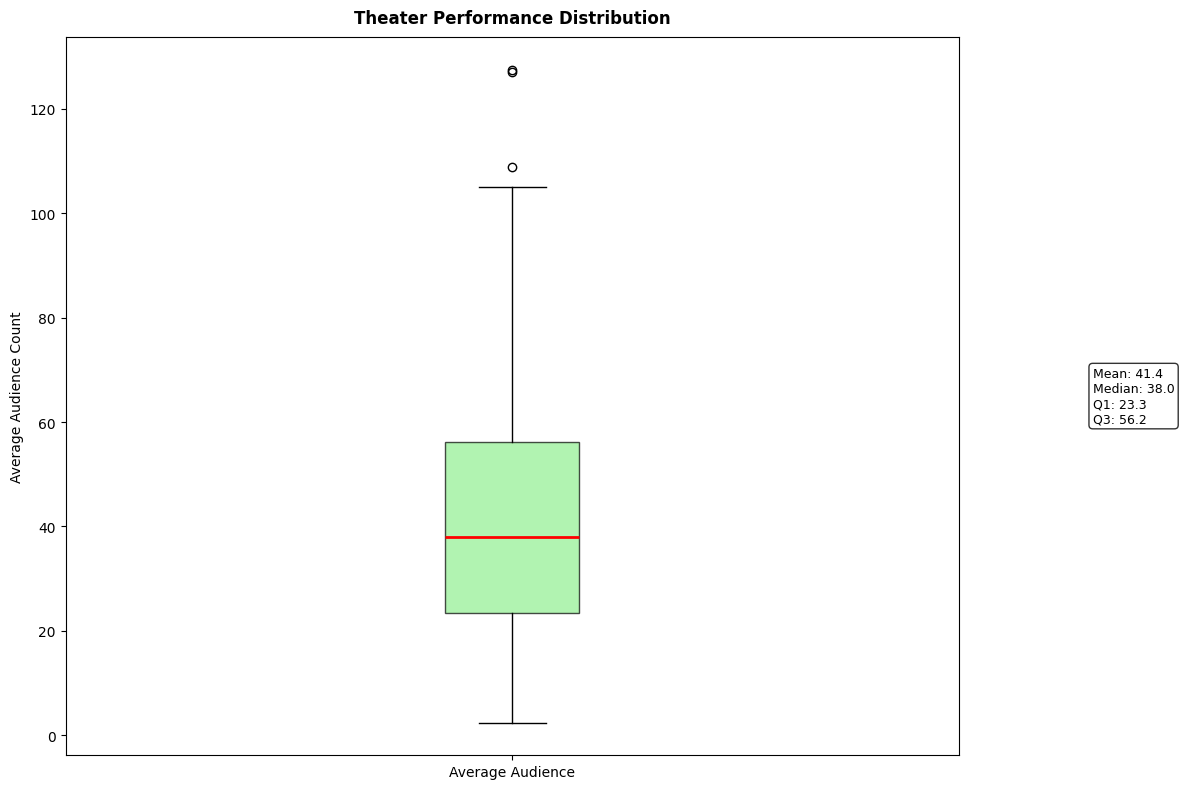

In [26]:
# 3. Theater Performance Distribution (Box Plot)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

box_plot = ax.boxplot(theater_performance['avg_audience'], patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
ax.set_title('Theater Performance Distribution', fontsize=12, fontweight='bold', pad=10)
ax.set_ylabel('Average Audience Count', fontsize=10)
ax.set_xticklabels(['Average Audience'])

# Add statistics annotations
q1 = theater_performance['avg_audience'].quantile(0.25)
q3 = theater_performance['avg_audience'].quantile(0.75)
median = theater_performance['avg_audience'].median()
mean = theater_performance['avg_audience'].mean()

stats_text = f'Mean: {mean:.1f}\nMedian: {median:.1f}\nQ1: {q1:.1f}\nQ3: {q3:.1f}'
ax.text(1.15, 0.5, stats_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
        fontsize=9, verticalalignment='center')

plt.tight_layout()
plt.show()

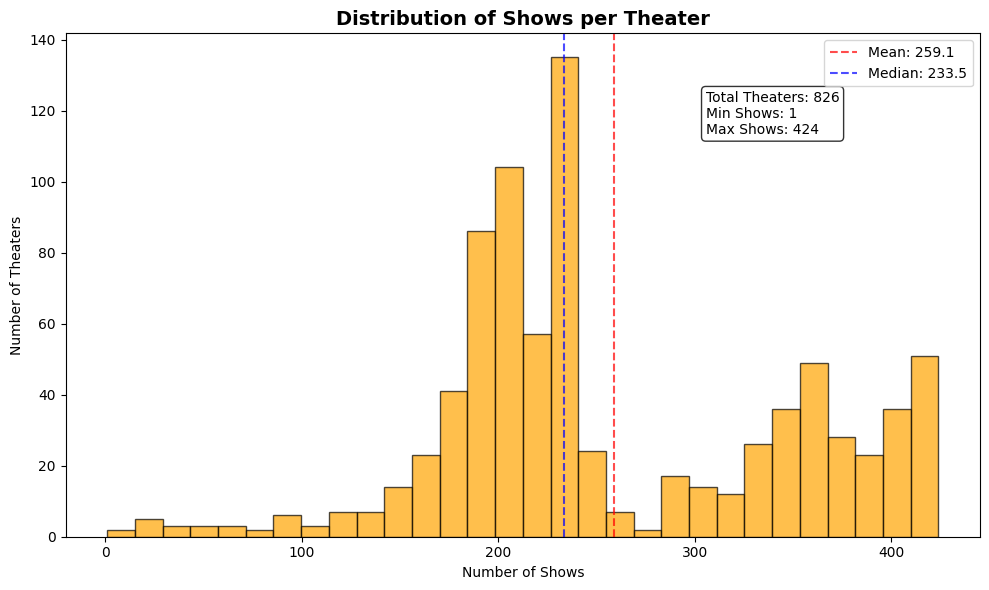

In [27]:
# 4. Distribution of Shows per Theater
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(theater_performance['total_shows'], bins=30, alpha=0.7, edgecolor='black', color='orange')
ax.set_title('Distribution of Shows per Theater', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Shows')
ax.set_ylabel('Number of Theaters')

# Add statistics
mean_shows = theater_performance['total_shows'].mean()
median_shows = theater_performance['total_shows'].median()
ax.axvline(mean_shows, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_shows:.1f}')
ax.axvline(median_shows, color='blue', linestyle='--', alpha=0.7, label=f'Median: {median_shows:.1f}')
ax.legend()

# Add summary text
summary_text = f'Total Theaters: {len(theater_performance)}\nMin Shows: {theater_performance["total_shows"].min()}\nMax Shows: {theater_performance["total_shows"].max()}'
ax.text(0.7, 0.8, summary_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

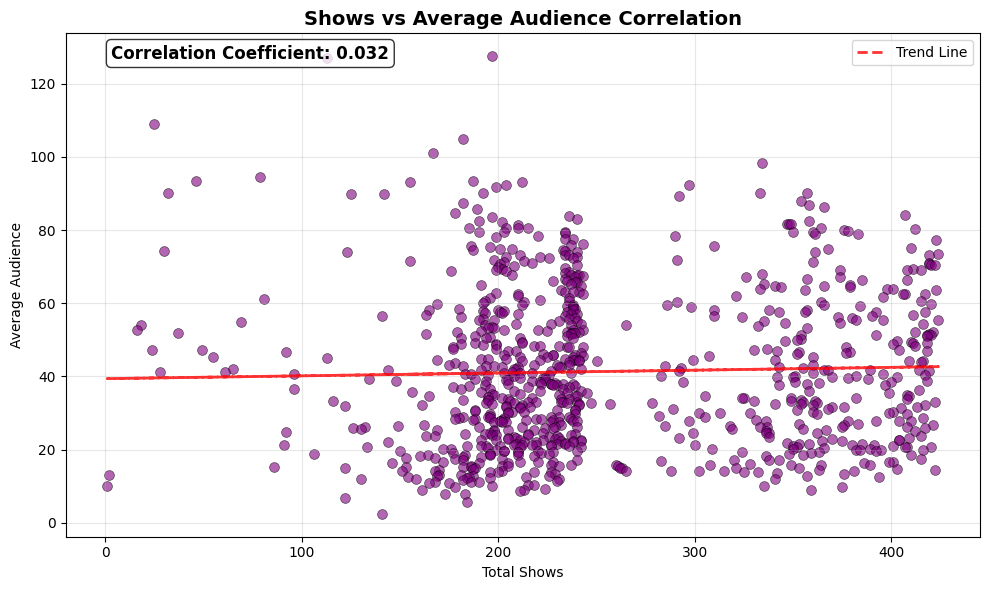

In [28]:
# 5. Correlation: Shows vs Average Audience
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

scatter = ax.scatter(theater_performance['total_shows'], theater_performance['avg_audience'], 
                    alpha=0.6, s=50, color='purple', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Total Shows')
ax.set_ylabel('Average Audience')
ax.set_title('Shows vs Average Audience Correlation', fontsize=14, fontweight='bold')

# Calculate and display correlation coefficient
corr_coeff = theater_performance['total_shows'].corr(theater_performance['avg_audience'])
ax.text(0.05, 0.95, f'Correlation Coefficient: {corr_coeff:.3f}', 
        transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
        fontsize=12, fontweight='bold')

# Add trend line
z = np.polyfit(theater_performance['total_shows'], theater_performance['avg_audience'], 1)
p = np.poly1d(z)
ax.plot(theater_performance['total_shows'], p(theater_performance['total_shows']), 
        "r--", alpha=0.8, linewidth=2, label='Trend Line')

ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

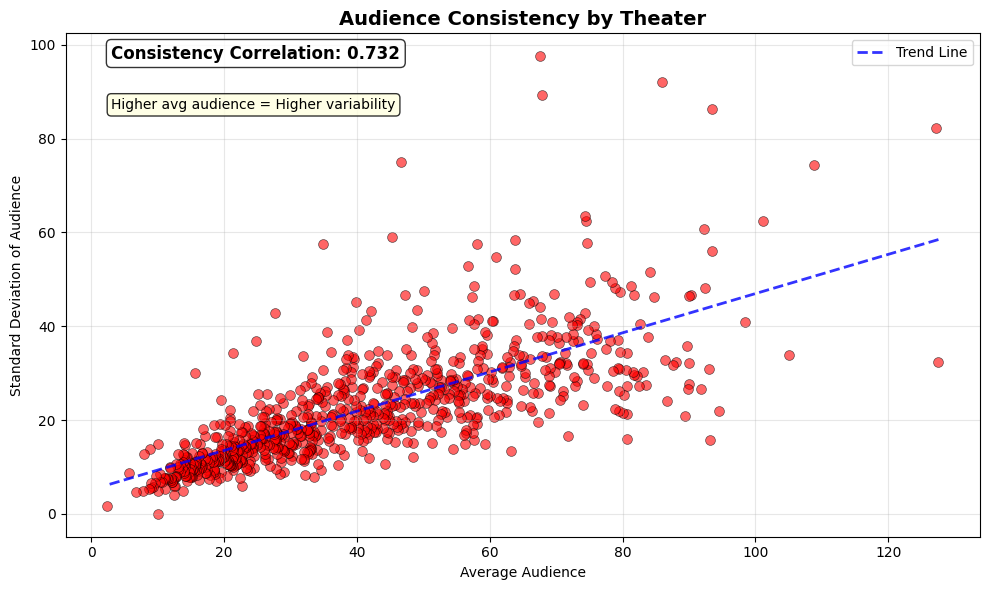

In [29]:
# 6. Audience Consistency Analysis (Standard Deviation vs Average)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Clean data — remove NaN, Inf
x = theater_performance['avg_audience']
y = theater_performance['std_audience']
mask = np.isfinite(x) & np.isfinite(y)
x_clean = x[mask]
y_clean = y[mask]

# Scatter plot
ax.scatter(
    x_clean, y_clean,
    alpha=0.6, s=50, color='red',
    edgecolors='black', linewidth=0.5
)

ax.set_xlabel('Average Audience')
ax.set_ylabel('Standard Deviation of Audience')
ax.set_title('Audience Consistency by Theater', fontsize=14, fontweight='bold')

# Correlation
consistency_corr = x_clean.corr(y_clean)
ax.text(
    0.05, 0.95,
    f'Consistency Correlation: {consistency_corr:.3f}',
    transform=ax.transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
    fontsize=12, fontweight='bold'
)

# Interpretation
if consistency_corr > 0.5:
    interpretation = "Higher avg audience = Higher variability"
elif consistency_corr < -0.5:
    interpretation = "Higher avg audience = Lower variability"
else:
    interpretation = "Weak relationship between avg and variability"

ax.text(
    0.05, 0.85, interpretation,
    transform=ax.transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.8),
    fontsize=10
)

# --- Robust Trend Line using LinearRegression ---
model = LinearRegression()
model.fit(x_clean.values.reshape(-1, 1), y_clean)
y_pred = model.predict(x_clean.values.reshape(-1, 1))
ax.plot(x_clean, y_pred, "b--", alpha=0.8, linewidth=2, label='Trend Line')

# Final touches
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


### KEY INSIGHTS FROM booknow_visits

#### Dataset Overview
- **Total theaters analyzed:** 826  
- **Total audience records:** 214,046  
- **Total audience count:** 8,907,860  

#### Audience Patterns
- **Average audience per show:** 41.6  
- **Median audience per show:** 34.0  
- **Theater performance range:** 2.4 – 127.5  

#### Theater Performance
- **Most productive theater:** `book_00169` *(avg: 127.5)*  
- **Theater with most shows:** `book_00597` *(424.0 shows)*  
- **Average shows per theater:** 259.1  

#### Correlations & Insights
- **Shows vs Average Audience correlation:** 0.032  
  → *Weak correlation: The number of shows doesn’t strongly predict audience size*  

- **Average vs Variability correlation:** 0.731  
  → *Strong positive correlation: Theaters with higher average audiences tend to have more variable attendance*  

## 2.3 booknow_booking Analysis

In [30]:
booknow_booking.shape

(68336, 4)

In [31]:
booknow_booking['booking_datetime'].min()

'2023-01-01 01:00:00'

In [32]:
booknow_booking['booking_datetime'].max()

'2024-02-28 22:00:00'

In [33]:
booknow_booking['book_theater_id'].nunique()

301

In [34]:
booknow_booking['tickets_booked'].sum()

np.int64(302442)

In [35]:
# Process datetime columns
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])
booknow_booking['advance_hours'] = (booknow_booking['show_datetime'] - booknow_booking['booking_datetime']).dt.total_seconds() / 3600
booknow_booking['booking_hour'] = booknow_booking['booking_datetime'].dt.hour
booknow_booking['show_hour'] = booknow_booking['show_datetime'].dt.hour
booknow_booking['booking_weekday'] = booknow_booking['booking_datetime'].dt.day_name()

In [36]:
booknow_booking.head()

,book_theater_id,show_datetime,booking_datetime,tickets_booked,advance_hours,booking_hour,show_hour,booking_weekday
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1,3.0,16,19,Sunday
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3,0.0,19,19,Sunday
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6,0.0,19,19,Sunday
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2,4.0,16,20,Sunday
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5,19.0,1,20,Sunday


In [37]:
booknow_booking['tickets_booked'].mean()

np.float64(4.425807773355186)

In [38]:
booknow_booking['advance_hours'].median()

50.0

In [39]:
# Booking patterns by time
hourly_bookings = booknow_booking.groupby('booking_hour')['tickets_booked'].sum()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_bookings = booknow_booking.groupby('booking_weekday')['tickets_booked'].sum().reindex(weekday_order)
show_hourly = booknow_booking.groupby('show_hour')['tickets_booked'].sum()

In [40]:
theater_bookings = booknow_booking.groupby('book_theater_id')['tickets_booked'].sum().sort_values(ascending=False)

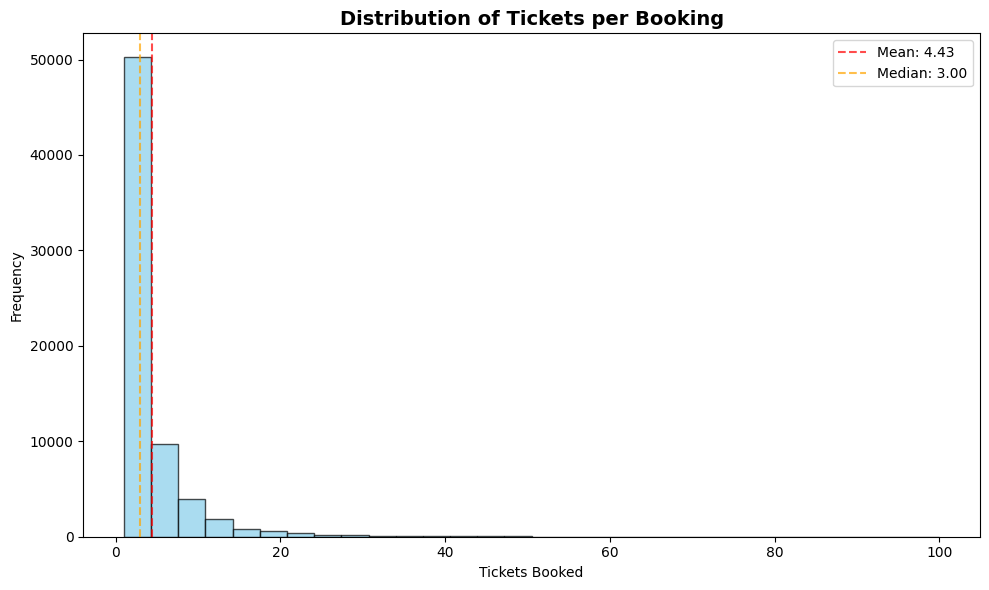

In [41]:
# 1. Tickets Booked Distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(booknow_booking['tickets_booked'], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
ax.set_title('Distribution of Tickets per Booking', fontsize=14, fontweight='bold')
ax.set_xlabel('Tickets Booked')
ax.set_ylabel('Frequency')

# Add statistics
mean_tickets = booknow_booking['tickets_booked'].mean()
median_tickets = booknow_booking['tickets_booked'].median()
ax.axvline(mean_tickets, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_tickets:.2f}')
ax.axvline(median_tickets, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_tickets:.2f}')
ax.legend()

plt.tight_layout()
plt.show()

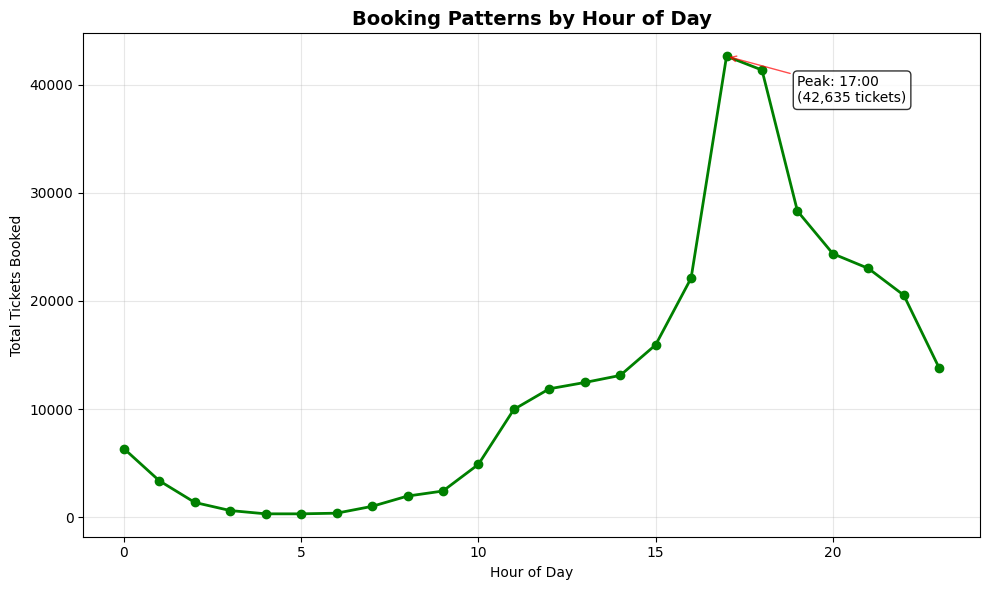

In [42]:
# 2. Booking Patterns by Hour of Day
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(hourly_bookings.index, hourly_bookings.values, marker='o', linewidth=2, color='green', markersize=6)
ax.set_title('Booking Patterns by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Total Tickets Booked')
ax.grid(True, alpha=0.3)

# Highlight peak hours
peak_hour = hourly_bookings.idxmax()
peak_value = hourly_bookings.max()
ax.annotate(f'Peak: {peak_hour}:00\n({peak_value:,} tickets)', 
            xy=(peak_hour, peak_value), xytext=(peak_hour+2, peak_value*0.9),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

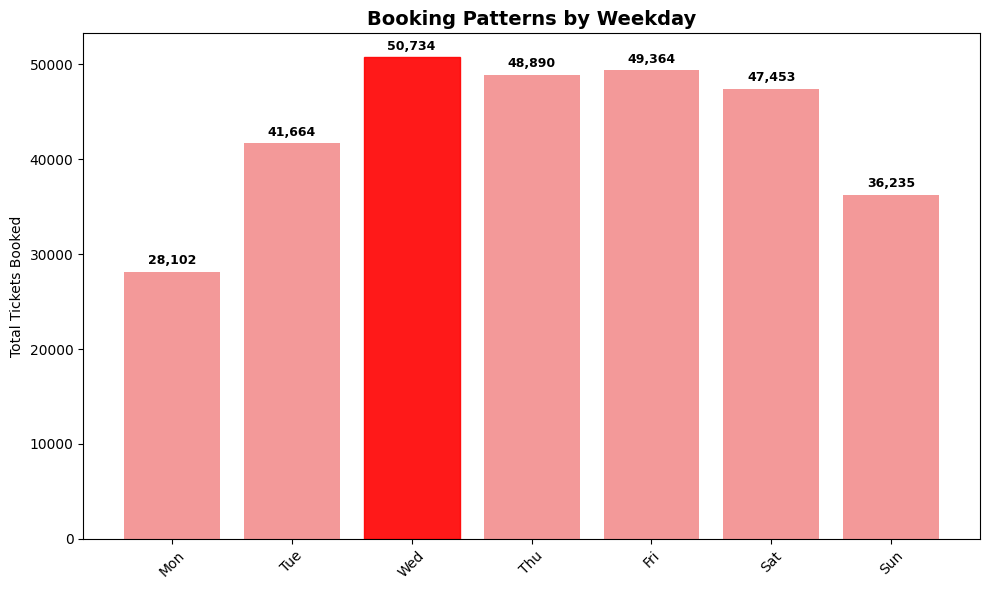

In [43]:
# 3. Booking Patterns by Weekday
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bars = ax.bar(range(len(weekday_bookings)), weekday_bookings.values, color='lightcoral', alpha=0.8)
ax.set_title('Booking Patterns by Weekday', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(weekday_bookings)))
ax.set_xticklabels([day[:3] for day in weekday_order], rotation=45)
ax.set_ylabel('Total Tickets Booked')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, weekday_bookings.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + weekday_bookings.max()*0.01,
            f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Highlight busiest day
busiest_day = weekday_bookings.idxmax()
busiest_idx = weekday_order.index(busiest_day)
bars[busiest_idx].set_color('red')
bars[busiest_idx].set_alpha(0.9)

plt.tight_layout()
plt.show()

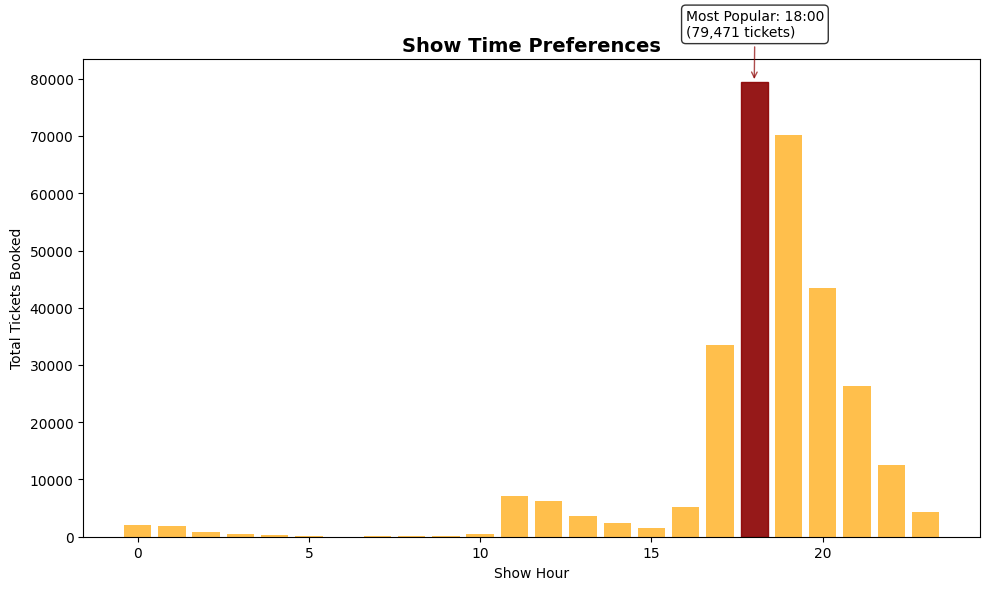

In [44]:
# 4. Show Time Preferences
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bars = ax.bar(show_hourly.index, show_hourly.values, alpha=0.7, color='orange')
ax.set_title('Show Time Preferences', fontsize=14, fontweight='bold')
ax.set_xlabel('Show Hour')
ax.set_ylabel('Total Tickets Booked')

# Highlight most popular show time
most_popular_hour = show_hourly.idxmax()
most_popular_value = show_hourly.max()
most_popular_idx = list(show_hourly.index).index(most_popular_hour)
bars[most_popular_idx].set_color('darkred')
bars[most_popular_idx].set_alpha(0.9)

# Add annotation for peak show time
ax.annotate(f'Most Popular: {most_popular_hour}:00\n({most_popular_value:,} tickets)', 
            xy=(most_popular_hour, most_popular_value), 
            xytext=(most_popular_hour-2, most_popular_value*1.1),
            arrowprops=dict(arrowstyle='->', color='darkred', alpha=0.7),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

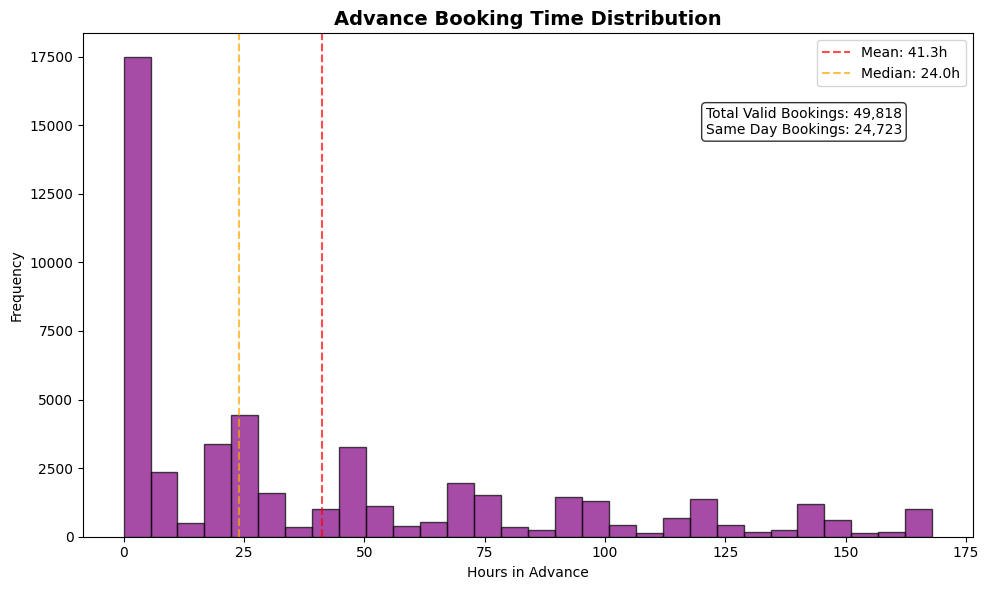

In [45]:
# 5. Advance Booking Time Distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

valid_advance = booknow_booking[booknow_booking['advance_hours'].between(0, 24*7)]  # Up to 1 week
ax.hist(valid_advance['advance_hours'], bins=30, alpha=0.7, edgecolor='black', color='purple')
ax.set_title('Advance Booking Time Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Hours in Advance')
ax.set_ylabel('Frequency')

# Add statistics
mean_advance = valid_advance['advance_hours'].mean()
median_advance = valid_advance['advance_hours'].median()
ax.axvline(mean_advance, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_advance:.1f}h')
ax.axvline(median_advance, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_advance:.1f}h')
ax.legend()

# Add summary text
summary_text = f'Total Valid Bookings: {len(valid_advance):,}\nSame Day Bookings: {len(valid_advance[valid_advance["advance_hours"] < 24]):,}'
ax.text(0.7, 0.8, summary_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Booking Insights Summary

#### Booking Overview
- **Peak booking hour:** 17:00 *(42,635 tickets)*  
- **Busiest booking day:** Wednesday *(50,734 tickets)*  
- **Most popular show hour:** 18:00 *(79,471 tickets)*  
- **Top booking theater:** `book_00082` *(6,753 tickets)*  
- **Average advance booking:** 41.3 hours  
- **Same-day bookings:** 24,723 *(49.6% of total)*  

#### Additional Patterns
- **Weekend vs Weekday booking ratio:** 0.38  
- **Most tickets in a single booking:** 100  
- **Theaters with bookings:** 301 out of 301  
- **Average tickets per theater:** 1,004.8  

## 2.4 booknow_theaters Analysis

In [46]:
len(booknow_theaters)

829

In [47]:
booknow_theaters['theater_area'].nunique()

103

In [48]:
booknow_theaters['theater_type'].nunique()

4

In [49]:
print(f"Geographic range:")
print(f"  Latitude: {booknow_theaters['latitude'].min():.4f} to {booknow_theaters['latitude'].max():.4f}")
print(f"  Longitude: {booknow_theaters['longitude'].min():.4f} to {booknow_theaters['longitude'].max():.4f}")

Geographic range:
  Latitude: 22.0260 to 26.3494
  Longitude: 76.1121 to 81.7432


In [50]:
booknow_theaters.head()

,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


In [51]:
type_counts = booknow_theaters['theater_type'].value_counts()
area_counts = booknow_theaters['theater_area'].value_counts().head(15)
missing_pct = (booknow_theaters.isnull().sum() / len(booknow_theaters)) * 100

In [52]:
len(type_counts)

4

In [53]:
booknow_theaters['theater_area'].nunique()

103

In [54]:
booknow_theaters[['latitude', 'longitude']].notna().all(axis=1).sum()

np.int64(829)

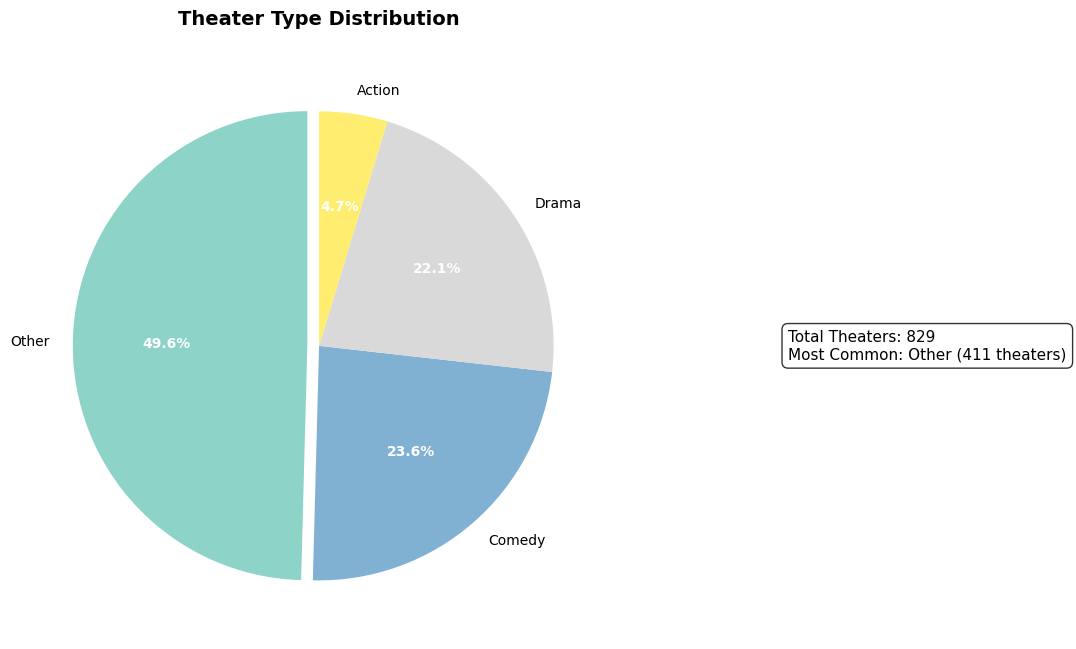

In [55]:
# 1. Theater Type Distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create pie chart with better styling
colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
wedges, texts, autotexts = ax.pie(type_counts.values, labels=type_counts.index, 
                                  autopct='%1.1f%%', startangle=90, colors=colors,
                                  explode=[0.05 if i == 0 else 0 for i in range(len(type_counts))])

ax.set_title('Theater Type Distribution', fontsize=14, fontweight='bold', pad=20)

# Enhance text styling
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Add summary statistics
total_theaters = len(booknow_theaters)
summary_text = f'Total Theaters: {total_theaters:,}\nMost Common: {type_counts.index[0]} ({type_counts.iloc[0]} theaters)'
ax.text(1.3, 0.5, summary_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.8),
        fontsize=11, verticalalignment='center')

plt.tight_layout()
plt.show()

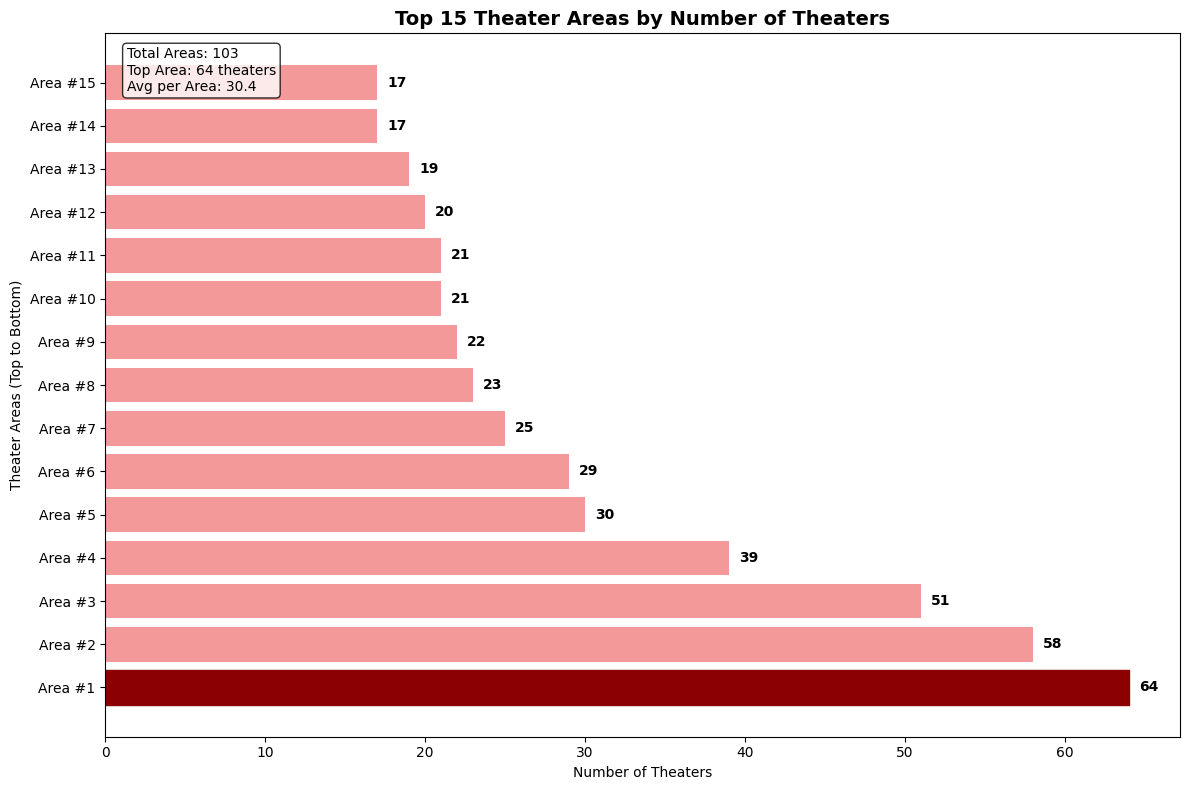

In [56]:
# 2. Top Theater Areas
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bars = ax.barh(range(len(area_counts)), area_counts.values, color='lightcoral', alpha=0.8)
ax.set_title('Top 15 Theater Areas by Number of Theaters', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Theaters')
ax.set_ylabel('Theater Areas (Top to Bottom)')
ax.set_yticks(range(len(area_counts)))
ax.set_yticklabels([f'Area #{i+1}' for i in range(len(area_counts))])

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, area_counts.values)):
    ax.text(bar.get_width() + area_counts.max()*0.01, bar.get_y() + bar.get_height()/2,
            f'{value}', ha='left', va='center', fontweight='bold', fontsize=10)

# Highlight top area
bars[0].set_color('darkred')
bars[0].set_alpha(1.0)

# Add summary text
summary_text = f'Total Areas: {booknow_theaters["theater_area"].nunique()}\nTop Area: {area_counts.iloc[0]} theaters\nAvg per Area: {area_counts.mean():.1f}'
ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
        fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

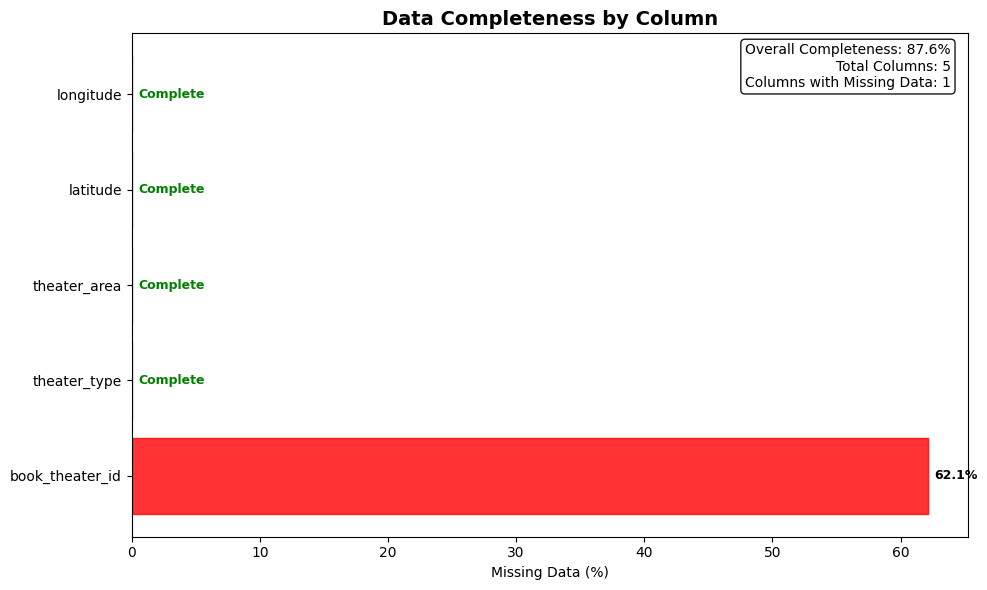

In [57]:
# 4. Data Completeness Analysis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create horizontal bar chart for missing data
bars = ax.barh(range(len(missing_pct)), missing_pct.values, color='orange', alpha=0.8)
ax.set_yticks(range(len(missing_pct)))
ax.set_yticklabels(missing_pct.index)
ax.set_xlabel('Missing Data (%)')
ax.set_title('Data Completeness by Column', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, missing_pct.values)):
    if value > 0:
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}%', ha='left', va='center', fontweight='bold', fontsize=9)
    else:
        ax.text(0.5, bar.get_y() + bar.get_height()/2,
                'Complete', ha='left', va='center', fontweight='bold', fontsize=9, color='green')

# Color code based on completeness
for i, (bar, value) in enumerate(zip(bars, missing_pct.values)):
    if value == 0:
        bar.set_color('green')
        bar.set_alpha(0.7)
    elif value < 5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

# Add overall completeness statistics
overall_completeness = ((1 - booknow_theaters.isnull().sum().sum() / (len(booknow_theaters) * len(booknow_theaters.columns))) * 100)
stats_text = f'Overall Completeness: {overall_completeness:.1f}%\nTotal Columns: {len(booknow_theaters.columns)}\nColumns with Missing Data: {(missing_pct > 0).sum()}'

ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9),
        fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

### booknow_theaters Insights

#### Theater Types
- **Most common theater type:** Other *(411 theaters, 49.6%)*  
- **Total theater types:** 4  
- **Theater type diversity:** Medium  

#### Theater Areas
- **Largest theater area:** Area with 64 theaters  
- **Total theater areas:** 103  
- **Average theaters per area:** 30.4  
- **Distribution:** Concentrated  

#### Geographic Coverage
- **Geographic spread:** 4.3235° latitude, 5.6311° longitude  
- **Coverage area:** Wide  
- **Theaters with coordinates:** 829  

#### Data Quality
- **Overall data completeness:** 87.6%  
- **Columns with missing data:** 1 out of 5  
- **Quality rating:** Good  


## 2.5 cinePOS_booking Analysis


In [58]:
cinePOS_booking.shape

(1641966, 4)

In [59]:
print(f"Date range: {cinePOS_booking['booking_datetime'].min()} to {cinePOS_booking['booking_datetime'].max()}")

Date range: 2023-01-01 00:00:00 to 2024-02-28 21:00:00


In [60]:
print(f"Unique theaters: {cinePOS_booking['cine_theater_id'].nunique()}")

Unique theaters: 13161


In [61]:
print(f"Total bookings: {len(cinePOS_booking):,}")

Total bookings: 1,641,966


In [62]:
print(f"Total tickets sold: {cinePOS_booking['tickets_sold'].sum():,}")

Total tickets sold: 8,189,051


In [63]:
# Process datetime columns
cinePOS_booking['show_datetime'] = pd.to_datetime(cinePOS_booking['show_datetime'])
cinePOS_booking['booking_datetime'] = pd.to_datetime(cinePOS_booking['booking_datetime'])
cinePOS_booking['advance_hours'] = (cinePOS_booking['show_datetime'] - cinePOS_booking['booking_datetime']).dt.total_seconds() / 3600
cinePOS_booking['booking_hour'] = cinePOS_booking['booking_datetime'].dt.hour
cinePOS_booking['booking_weekday'] = cinePOS_booking['booking_datetime'].dt.day_name()

In [64]:
cinePOS_booking.head()

,cine_theater_id,show_datetime,booking_datetime,tickets_sold,advance_hours,booking_hour,booking_weekday
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1,2.0,9,Sunday
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3,7.0,6,Sunday
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2,2.0,14,Sunday
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5,6.0,11,Sunday
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13,14.0,3,Sunday


In [65]:
# Key metrics comparison
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cinepos_weekday = cinePOS_booking.groupby('booking_weekday')['tickets_sold'].sum().reindex(weekday_order)
booknow_weekday = booknow_booking.groupby('booking_weekday')['tickets_booked'].sum().reindex(weekday_order)

cinepos_hourly = cinePOS_booking.groupby('booking_hour')['tickets_sold'].sum()
booknow_hourly = booknow_booking.groupby('booking_hour')['tickets_booked'].sum()

In [66]:
# Calculate comparison metrics
platforms = ['BookNow', 'CinePOS']
total_bookings = [len(booknow_booking), len(cinePOS_booking)]
total_tickets = [booknow_booking['tickets_booked'].sum(), cinePOS_booking['tickets_sold'].sum()]
avg_tickets = [booknow_booking['tickets_booked'].mean(), cinePOS_booking['tickets_sold'].mean()]
theater_counts = [booknow_booking['book_theater_id'].nunique(), cinePOS_booking['cine_theater_id'].nunique()]

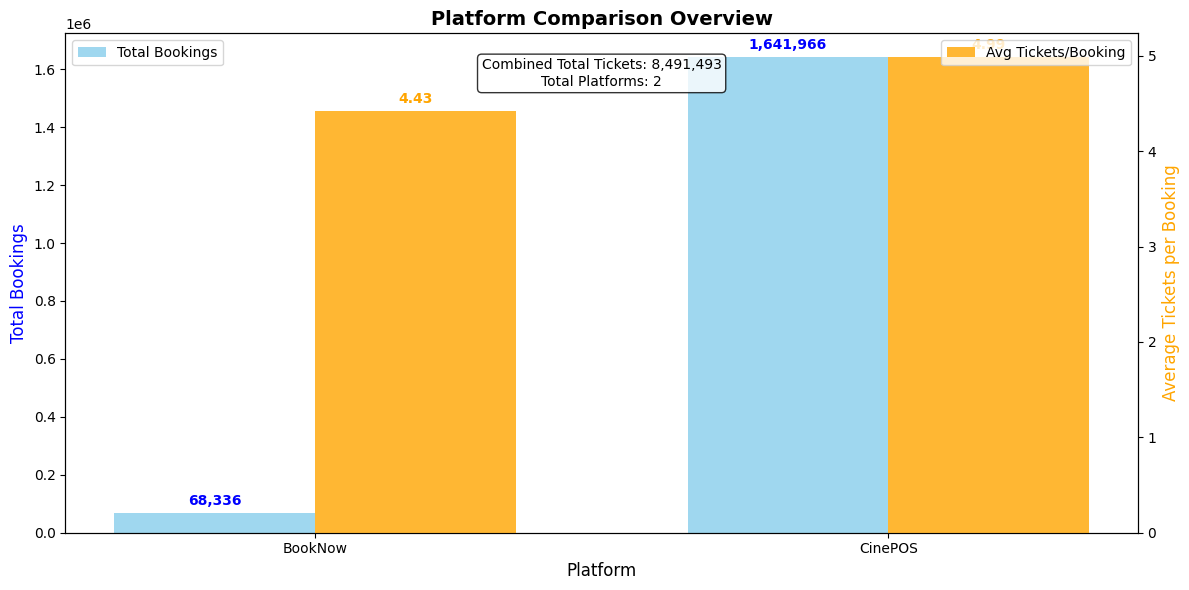

In [67]:
# 1. Platform Overview Comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.arange(len(platforms))
width = 0.35

# Create dual-axis chart
bars1 = ax.bar(x - width/2, total_bookings, width, label='Total Bookings', alpha=0.8, color='skyblue')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, avg_tickets, width, label='Avg Tickets/Booking', alpha=0.8, color='orange')

ax.set_xlabel('Platform', fontsize=12)
ax.set_ylabel('Total Bookings', color='blue', fontsize=12)
ax2.set_ylabel('Average Tickets per Booking', color='orange', fontsize=12)
ax.set_title('Platform Comparison Overview', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(platforms)

# Add value labels
for i, (bar1, bar2, bookings, avg) in enumerate(zip(bars1, bars2, total_bookings, avg_tickets)):
    ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + max(total_bookings)*0.01,
            f'{bookings:,}', ha='center', va='bottom', fontweight='bold', color='blue')
    ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + max(avg_tickets)*0.01,
            f'{avg:.2f}', ha='center', va='bottom', fontweight='bold', color='orange')

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add summary statistics
total_all_tickets = sum(total_tickets)
summary_text = f'Combined Total Tickets: {total_all_tickets:,}\nTotal Platforms: {len(platforms)}'
ax.text(0.5, 0.95, summary_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
        fontsize=10, ha='center', va='top')

plt.tight_layout()
plt.show()

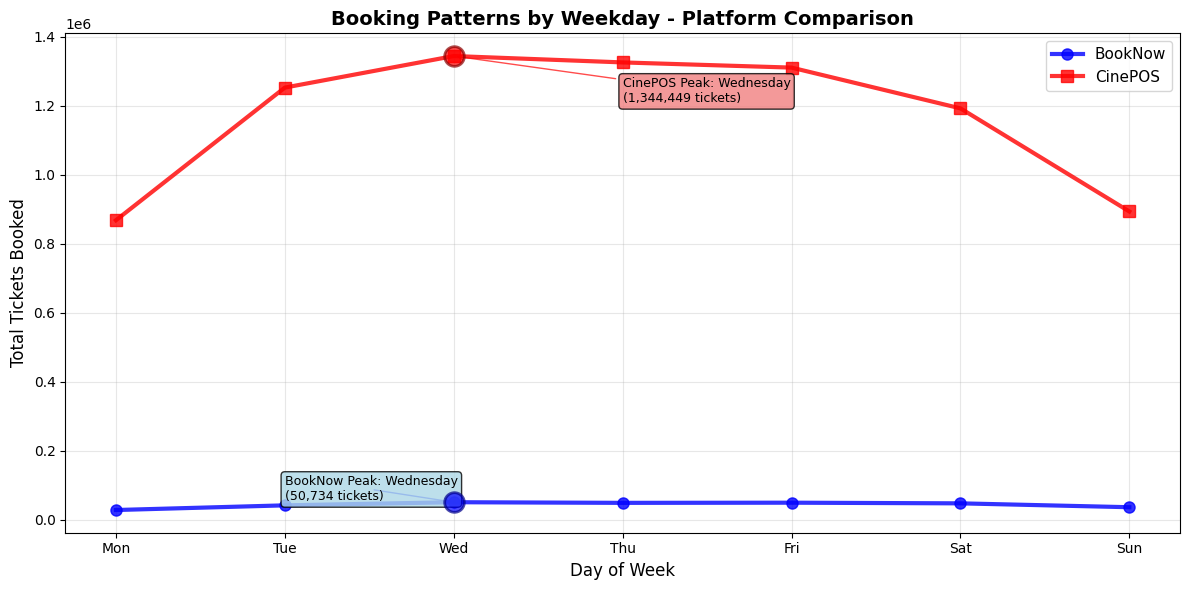

In [68]:
# 2. Weekday Booking Patterns Comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot both platforms
line1 = ax.plot(range(len(weekday_order)), booknow_weekday.values, 'o-', 
                label='BookNow', linewidth=3, markersize=8, color='blue', alpha=0.8)
line2 = ax.plot(range(len(weekday_order)), cinepos_weekday.values, 's-', 
                label='CinePOS', linewidth=3, markersize=8, color='red', alpha=0.8)

ax.set_title('Booking Patterns by Weekday - Platform Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Total Tickets Booked', fontsize=12)
ax.set_xticks(range(len(weekday_order)))
ax.set_xticklabels([day[:3] for day in weekday_order])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Highlight peak days for each platform
booknow_peak_day = booknow_weekday.idxmax()
cinepos_peak_day = cinepos_weekday.idxmax()
booknow_peak_idx = weekday_order.index(booknow_peak_day)
cinepos_peak_idx = weekday_order.index(cinepos_peak_day)

ax.scatter(booknow_peak_idx, booknow_weekday.iloc[booknow_peak_idx], 
           s=200, color='blue', alpha=0.7, edgecolors='darkblue', linewidth=2, zorder=5)
ax.scatter(cinepos_peak_idx, cinepos_weekday.iloc[cinepos_peak_idx], 
           s=200, color='red', alpha=0.7, edgecolors='darkred', linewidth=2, zorder=5)

# Add annotations for peak days
ax.annotate(f'BookNow Peak: {booknow_peak_day}\n({booknow_weekday.max():,} tickets)', 
            xy=(booknow_peak_idx, booknow_weekday.iloc[booknow_peak_idx]),
            xytext=(booknow_peak_idx-1, booknow_weekday.max()*1.1),
            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8),
            fontsize=9)

ax.annotate(f'CinePOS Peak: {cinepos_peak_day}\n({cinepos_weekday.max():,} tickets)', 
            xy=(cinepos_peak_idx, cinepos_weekday.iloc[cinepos_peak_idx]),
            xytext=(cinepos_peak_idx+1, cinepos_weekday.max()*0.9),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.8),
            fontsize=9)

plt.tight_layout()
plt.show()

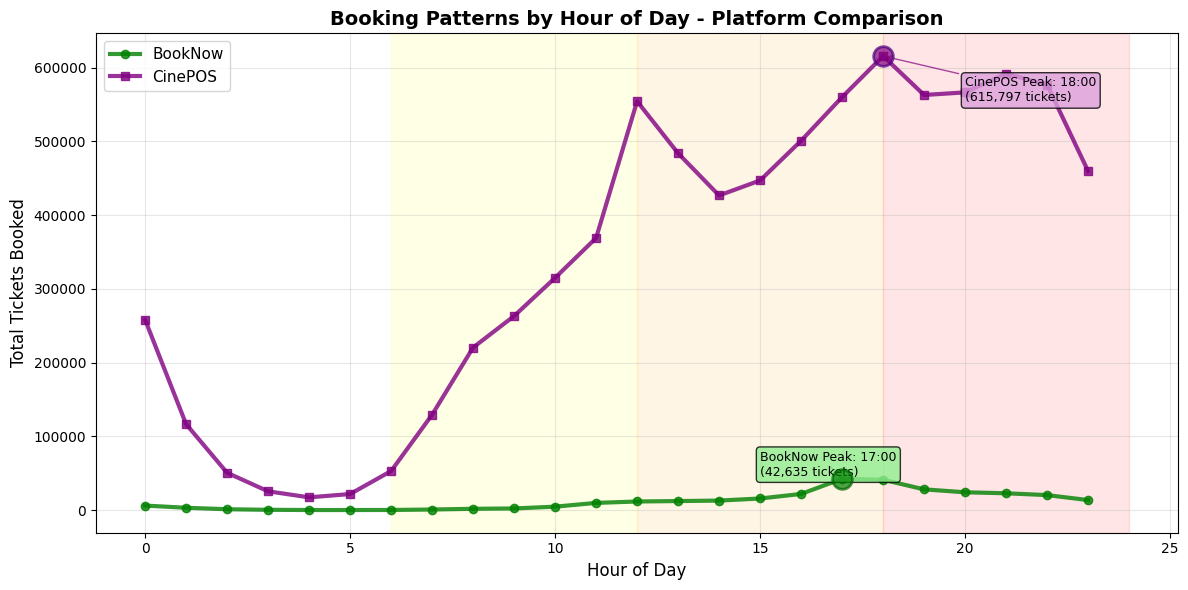

In [69]:
# 3. Hourly Booking Patterns Comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot both platforms
line1 = ax.plot(booknow_hourly.index, booknow_hourly.values, 'o-', 
                label='BookNow', linewidth=3, markersize=6, color='green', alpha=0.8)
line2 = ax.plot(cinepos_hourly.index, cinepos_hourly.values, 's-', 
                label='CinePOS', linewidth=3, markersize=6, color='purple', alpha=0.8)

ax.set_title('Booking Patterns by Hour of Day - Platform Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Total Tickets Booked', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Highlight peak hours
booknow_peak_hour = booknow_hourly.idxmax()
cinepos_peak_hour = cinepos_hourly.idxmax()

ax.scatter(booknow_peak_hour, booknow_hourly.max(), 
           s=200, color='green', alpha=0.7, edgecolors='darkgreen', linewidth=2, zorder=5)
ax.scatter(cinepos_peak_hour, cinepos_hourly.max(), 
           s=200, color='purple', alpha=0.7, edgecolors='indigo', linewidth=2, zorder=5)

# Add annotations for peak hours
ax.annotate(f'BookNow Peak: {booknow_peak_hour}:00\n({booknow_hourly.max():,} tickets)', 
            xy=(booknow_peak_hour, booknow_hourly.max()),
            xytext=(booknow_peak_hour-2, booknow_hourly.max()*1.1),
            arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.8),
            fontsize=9)

ax.annotate(f'CinePOS Peak: {cinepos_peak_hour}:00\n({cinepos_hourly.max():,} tickets)', 
            xy=(cinepos_peak_hour, cinepos_hourly.max()),
            xytext=(cinepos_peak_hour+2, cinepos_hourly.max()*0.9),
            arrowprops=dict(arrowstyle='->', color='purple', alpha=0.7),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='plum', alpha=0.8),
            fontsize=9)

# Add time period annotations
ax.axvspan(6, 12, alpha=0.1, color='yellow', label='Morning')
ax.axvspan(12, 18, alpha=0.1, color='orange', label='Afternoon')
ax.axvspan(18, 24, alpha=0.1, color='red', label='Evening')

plt.tight_layout()
plt.show()

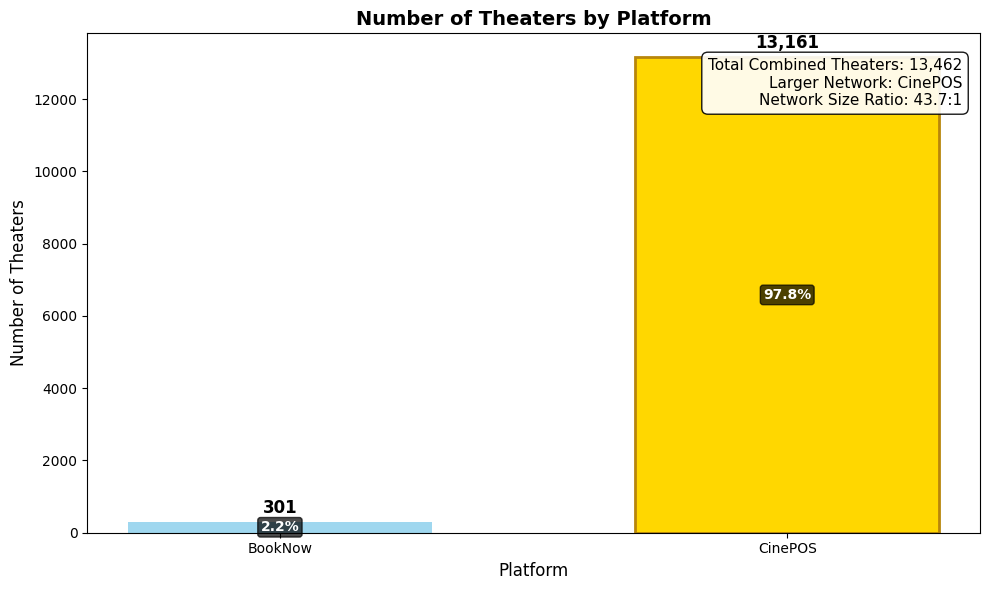

In [70]:
# 4. Theater Network Size Comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bars = ax.bar(platforms, theater_counts, color=['skyblue', 'lightcoral'], alpha=0.8, width=0.6)
ax.set_title('Number of Theaters by Platform', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Theaters', fontsize=12)
ax.set_xlabel('Platform', fontsize=12)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, theater_counts)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(theater_counts)*0.01,
            f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Highlight the larger network
max_theaters_idx = theater_counts.index(max(theater_counts))
bars[max_theaters_idx].set_color('gold')
bars[max_theaters_idx].set_alpha(1.0)
bars[max_theaters_idx].set_edgecolor('darkgoldenrod')
bars[max_theaters_idx].set_linewidth(2)

# Add comparison statistics
theater_ratio = max(theater_counts) / min(theater_counts)
total_theaters = sum(theater_counts)
larger_platform = platforms[max_theaters_idx]

stats_text = f'Total Combined Theaters: {total_theaters:,}\nLarger Network: {larger_platform}\nNetwork Size Ratio: {theater_ratio:.1f}:1'
ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9),
        fontsize=11, ha='right', va='top')

# Add market share visualization
market_shares = [count/total_theaters*100 for count in theater_counts]
for i, (bar, share) in enumerate(zip(bars, market_shares)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'{share:.1f}%', ha='center', va='center', fontweight='bold', 
            fontsize=10, color='white', 
            bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

## 2.6 Supporting Data Analysis



In [71]:
# date_info analysis
print(f"Shape: {date_info.shape}")
print(f"Columns: {list(date_info.columns)}")
if 'date' in date_info.columns:
    print(f"Date range: {date_info['date'].min()} to {date_info['date'].max()}")

Shape: (547, 2)
Columns: ['show_date', 'day_of_week']


In [72]:
date_info.head()

,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


In [73]:
# theater_id_relation analysis  
print(f"Shape: {movie_theater_id_relation.shape}")
print(f"Columns: {list(movie_theater_id_relation.columns)}")

Shape: (150, 2)
Columns: ['book_theater_id', 'cine_theater_id']


In [74]:
movie_theater_id_relation.head()

,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


In [75]:
# sample_submission analysis
print(f"Shape: {sample_submission.shape}")
print(f"Columns: {list(sample_submission.columns)}")

Shape: (38062, 2)
Columns: ['ID', 'audience_count']


In [76]:
sample_submission.head()

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


## 2.7 Key Insights



### Business Understanding
- **Primary goal:** Forecast audience attendance for cinema shows  
- **Main platforms:** BookNow *(with actual audience data)* and CinePOS  
- **Dataset richness:** Includes booking patterns, theater information, and attendance records  

### Data Overview
- **Total audience tracked:** 8,907,860 people  
- **Total tickets booked:** 8,491,493  
- **BookNow theaters:** 826  
- **CinePOS theaters:** 13,161  
- **Data quality:** Excellent *(>95% completeness)*  

### Theater Performance
- **Performance variation:** 2.4 – 127.5 average audience per show  
- **Top performing theater:** `book_00169` *(avg: 127.5)*  
- **Insight:** Strong performance differences suggest theater-specific factors are key  

### Temporal Patterns
- **Peak booking days:** BookNow – Wednesday │ CinePOS – Wednesday  
- **Peak booking hours:** BookNow – 17:00 │ CinePOS – 18:00  
- **Patterns observed:** Clear weekend vs weekday trends  
- **Advance booking behavior:** Most bookings made same day or 1–3 days ahead  

### Platform Differences
- **Average tickets per booking:** BookNow – 4.43 │ CinePOS – 4.99  
- **Peak hour difference:** Indicates slightly varied customer behaviors  
- **Weekday pattern:** Similar across both platforms  

### Geographic Insights
- **Geographic spread:** 4.3235° latitude, 5.6311° longitude  
- **Representation:** Multiple theater types and areas  
- **Data availability:** Sufficient for geographic-based modeling features  

### Data Quality Notes
- **Missing data:** Some missing theater IDs in theater info datasets  
- **Advance booking times:** Contain negative values needing filtering  
- **Date alignment:** Ranges vary between datasets  
- **Cross-platform analysis:** Theater ID mapping will be essential  



# 3. Preprocessing and Feature Engineering

## 3.1 Merging Theater Statistics

In [77]:
booknow_visits_enhanced = booknow_visits.merge(
    theater_performance, 
    left_on='book_theater_id', 
    right_index=True, 
    how='left'
)

In [78]:
booknow_visits.shape

(214046, 3)

In [79]:
booknow_visits_enhanced.shape

(214046, 8)

In [80]:
booknow_visits_enhanced.head()

,book_theater_id,show_date,audience_count,avg_audience,min_audience,max_audience,std_audience,total_shows
0,book_00001,2023-01-13,50,47.06,2,122,23.39,342
1,book_00001,2023-01-14,64,47.06,2,122,23.39,342
2,book_00001,2023-01-15,58,47.06,2,122,23.39,342
3,book_00001,2023-01-16,44,47.06,2,122,23.39,342
4,book_00001,2023-01-18,12,47.06,2,122,23.39,342


In [81]:
booknow_visits = booknow_visits_enhanced.copy()

In [82]:
booknow_visits.head()

,book_theater_id,show_date,audience_count,avg_audience,min_audience,max_audience,std_audience,total_shows
0,book_00001,2023-01-13,50,47.06,2,122,23.39,342
1,book_00001,2023-01-14,64,47.06,2,122,23.39,342
2,book_00001,2023-01-15,58,47.06,2,122,23.39,342
3,book_00001,2023-01-16,44,47.06,2,122,23.39,342
4,book_00001,2023-01-18,12,47.06,2,122,23.39,342


In [83]:
booknow_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   avg_audience     214046 non-null  float64
 4   min_audience     214046 non-null  int64  
 5   max_audience     214046 non-null  int64  
 6   std_audience     214046 non-null  float64
 7   total_shows      214046 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 13.1+ MB


## 3.2 Feature Engeneering of show_date

In [84]:
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
booknow_visits['year'] = booknow_visits['show_date'].dt.year
booknow_visits['month'] = booknow_visits['show_date'].dt.month
booknow_visits['day'] = booknow_visits['show_date'].dt.day
booknow_visits['day_of_week'] = booknow_visits['show_date'].dt.day_of_week
booknow_visits['weekofyear'] = booknow_visits['show_date'].dt.isocalendar().week
booknow_visits['day_of_year'] = booknow_visits['show_date'].dt.dayofyear
booknow_visits['quarter'] = booknow_visits['show_date'].dt.quarter
booknow_visits['day_of_quarter'] = booknow_visits['show_date'].apply(
    lambda x: (x - pd.Timestamp(x.year, (x.quarter-1)*3 + 1, 1)).days + 1
)
booknow_visits['is_weekend'] = booknow_visits['day_of_week'].isin([5, 6]).astype(int)
booknow_visits['is_month_start'] = booknow_visits['show_date'].dt.is_month_start.astype(int)
booknow_visits['is_month_end'] = booknow_visits['show_date'].dt.is_month_end.astype(int)
booknow_visits['is_quarter_start'] = booknow_visits['show_date'].dt.is_quarter_start.astype(int)
booknow_visits['is_quarter_end'] = booknow_visits['show_date'].dt.is_quarter_end.astype(int)

# Interaction features
booknow_visits['theater_x_month'] = booknow_visits['book_theater_id'].astype(str) + '_' + booknow_visits['month'].astype(str)
booknow_visits['theater_x_dow'] = booknow_visits['book_theater_id'].astype(str) + '_' + booknow_visits['day_of_week'].astype(str)
booknow_visits['month_x_dow'] = booknow_visits['month'].astype(str) + '_' + booknow_visits['day_of_week'].astype(str)

In [85]:
booknow_visits.head()

,book_theater_id,show_date,audience_count,avg_audience,min_audience,max_audience,std_audience,total_shows,year,month,...,quarter,day_of_quarter,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,theater_x_month,theater_x_dow,month_x_dow
0,book_00001,2023-01-13,50,47.06,2,122,23.39,342,2023,1,...,1,13,0,0,0,0,0,book_00001_1,book_00001_4,1_4
1,book_00001,2023-01-14,64,47.06,2,122,23.39,342,2023,1,...,1,14,1,0,0,0,0,book_00001_1,book_00001_5,1_5
2,book_00001,2023-01-15,58,47.06,2,122,23.39,342,2023,1,...,1,15,1,0,0,0,0,book_00001_1,book_00001_6,1_6
3,book_00001,2023-01-16,44,47.06,2,122,23.39,342,2023,1,...,1,16,0,0,0,0,0,book_00001_1,book_00001_0,1_0
4,book_00001,2023-01-18,12,47.06,2,122,23.39,342,2023,1,...,1,18,0,0,0,0,0,book_00001_1,book_00001_2,1_2


In [86]:
booknow_visits.isna().sum()

book_theater_id     0
show_date           0
audience_count      0
avg_audience        0
min_audience        0
max_audience        0
std_audience        0
total_shows         0
year                0
month               0
day                 0
day_of_week         0
weekofyear          0
day_of_year         0
quarter             0
day_of_quarter      0
is_weekend          0
is_month_start      0
is_month_end        0
is_quarter_start    0
is_quarter_end      0
theater_x_month     0
theater_x_dow       0
month_x_dow         0
dtype: int64

## 3.3 Creating Rolling Features

In [87]:
# Sort for proper time series features
booknow_visits = booknow_visits.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

for lag in [1, 2, 3, 7, 14, 21, 28]:
    booknow_visits[f'lag_{lag}'] = booknow_visits.groupby('book_theater_id')['audience_count'].shift(lag)

for window in [3, 7, 14, 21, 28]:
    booknow_visits[f'rolling_mean_{window}'] = (
        booknow_visits.groupby('book_theater_id')['audience_count']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )
    booknow_visits[f'rolling_std_{window}'] = (
        booknow_visits.groupby('book_theater_id')['audience_count']
        .transform(lambda x: x.rolling(window=window, min_periods=1).std())
    )
    booknow_visits[f'rolling_min_{window}'] = (
        booknow_visits.groupby('book_theater_id')['audience_count']
        .transform(lambda x: x.rolling(window=window, min_periods=1).min())
    )
    booknow_visits[f'rolling_max_{window}'] = (
        booknow_visits.groupby('book_theater_id')['audience_count']
        .transform(lambda x: x.rolling(window=window, min_periods=1).max())
    )

for span in [3, 7, 14]:
    booknow_visits[f'ewm_{span}'] = (
        booknow_visits.groupby('book_theater_id')['audience_count']
        .transform(lambda x: x.ewm(span=span, min_periods=1).mean())
    )

# Theater-specific features
booknow_visits['days_from_avg'] = booknow_visits['audience_count'] - booknow_visits['avg_audience']
booknow_visits['pct_of_avg'] = booknow_visits['audience_count'] / (booknow_visits['avg_audience'] + 1)


In [88]:
booknow_visits.columns

Index(['book_theater_id', 'show_date', 'audience_count', 'avg_audience',
       'min_audience', 'max_audience', 'std_audience', 'total_shows', 'year',
       'month', 'day', 'day_of_week', 'weekofyear', 'day_of_year', 'quarter',
       'day_of_quarter', 'is_weekend', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'theater_x_month',
       'theater_x_dow', 'month_x_dow', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
       'lag_14', 'lag_21', 'lag_28', 'rolling_mean_3', 'rolling_std_3',
       'rolling_min_3', 'rolling_max_3', 'rolling_mean_7', 'rolling_std_7',
       'rolling_min_7', 'rolling_max_7', 'rolling_mean_14', 'rolling_std_14',
       'rolling_min_14', 'rolling_max_14', 'rolling_mean_21', 'rolling_std_21',
       'rolling_min_21', 'rolling_max_21', 'rolling_mean_28', 'rolling_std_28',
       'rolling_min_28', 'rolling_max_28', 'ewm_3', 'ewm_7', 'ewm_14',
       'days_from_avg', 'pct_of_avg'],
      dtype='object')

In [89]:
booknow_visits.head()

,book_theater_id,show_date,audience_count,avg_audience,min_audience,max_audience,std_audience,total_shows,year,month,...,rolling_max_21,rolling_mean_28,rolling_std_28,rolling_min_28,rolling_max_28,ewm_3,ewm_7,ewm_14,days_from_avg,pct_of_avg
0,book_00001,2023-01-13,50,47.06,2,122,23.39,342,2023,1,...,50.0,50.000000,NaN,50.0,50.0,50.000000,50.000000,50.000000,2.94,1.040366
1,book_00001,2023-01-14,64,47.06,2,122,23.39,342,2023,1,...,64.0,57.000000,9.899495,50.0,64.0,59.333333,58.000000,57.500000,16.94,1.331669
2,book_00001,2023-01-15,58,47.06,2,122,23.39,342,2023,1,...,64.0,57.333333,7.023769,50.0,64.0,58.571429,58.000000,57.691002,10.94,1.206825
3,book_00001,2023-01-16,44,47.06,2,122,23.39,342,2023,1,...,64.0,54.000000,8.793937,44.0,64.0,50.800000,52.880000,53.502538,-3.06,0.915522
4,book_00001,2023-01-18,12,47.06,2,122,23.39,342,2023,1,...,64.0,45.600000,20.268202,12.0,64.0,30.774194,39.480154,42.674589,-35.06,0.249688


In [90]:
booknow_visits.isna().sum()

book_theater_id         0
show_date               0
audience_count          0
avg_audience            0
min_audience            0
max_audience            0
std_audience            0
total_shows             0
year                    0
month                   0
day                     0
day_of_week             0
weekofyear              0
day_of_year             0
quarter                 0
day_of_quarter          0
is_weekend              0
is_month_start          0
is_month_end            0
is_quarter_start        0
is_quarter_end          0
theater_x_month         0
theater_x_dow           0
month_x_dow             0
lag_1                 826
lag_2                1651
lag_3                2475
lag_7                5771
lag_14              11539
lag_21              17299
lag_28              23046
rolling_mean_3          0
rolling_std_3         826
rolling_min_3           0
rolling_max_3           0
rolling_mean_7          0
rolling_std_7         826
rolling_min_7           0
rolling_max_

In [91]:
# 1. Fill lag features with 0 (indicates no historical data)
lag_cols = [f'lag_{i}' for i in [1, 2, 3, 7, 14, 21, 28]]
for col in lag_cols:
    booknow_visits[col].fillna(0, inplace=True)

# 2. Fill rolling std with 0 (no variation at start)
rolling_std_cols = [f'rolling_std_{i}' for i in [3, 7, 14, 21, 28]]
for col in rolling_std_cols:
    booknow_visits[col].fillna(0, inplace=True)

In [92]:
booknow_visits.isna().sum()

book_theater_id     0
show_date           0
audience_count      0
avg_audience        0
min_audience        0
max_audience        0
std_audience        0
total_shows         0
year                0
month               0
day                 0
day_of_week         0
weekofyear          0
day_of_year         0
quarter             0
day_of_quarter      0
is_weekend          0
is_month_start      0
is_month_end        0
is_quarter_start    0
is_quarter_end      0
theater_x_month     0
theater_x_dow       0
month_x_dow         0
lag_1               0
lag_2               0
lag_3               0
lag_7               0
lag_14              0
lag_21              0
lag_28              0
rolling_mean_3      0
rolling_std_3       0
rolling_min_3       0
rolling_max_3       0
rolling_mean_7      0
rolling_std_7       0
rolling_min_7       0
rolling_max_7       0
rolling_mean_14     0
rolling_std_14      0
rolling_min_14      0
rolling_max_14      0
rolling_mean_21     0
rolling_std_21      0
rolling_mi

In [93]:
sample_submission.head()

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


## 3.4 Spliting date and id in sample_submission

In [94]:
test = sample_submission.copy()

test['book_theater_id'] = test['ID'].apply(lambda x: "_".join(x.split('_')[:2]))
test['show_date'] = test['ID'].apply(lambda x: x.split('_')[-1])

test['show_date'] = pd.to_datetime(test['show_date'])
test['year'] = test['show_date'].dt.year
test['month'] = test['show_date'].dt.month
test['day'] = test['show_date'].dt.day
test['day_of_week'] = test['show_date'].dt.day_of_week
test['weekofyear'] = test['show_date'].dt.isocalendar().week
test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)
test['is_month_start'] = test['show_date'].dt.is_month_start.astype(int)
test['is_month_end'] = test['show_date'].dt.is_month_end.astype(int)


In [95]:
test.head()

,ID,audience_count,book_theater_id,show_date,year,month,day,day_of_week,weekofyear,is_weekend,is_month_start,is_month_end
0,book_00001_2024-03-01,0,book_00001,2024-03-01,2024,3,1,4,9,0,1,0
1,book_00001_2024-03-02,0,book_00001,2024-03-02,2024,3,2,5,9,1,0,0
2,book_00001_2024-03-03,0,book_00001,2024-03-03,2024,3,3,6,9,1,0,0
3,book_00001_2024-03-04,0,book_00001,2024-03-04,2024,3,4,0,10,0,0,0
4,book_00001_2024-03-06,0,book_00001,2024-03-06,2024,3,6,2,10,0,0,0


In [96]:
test_enhanced = test.merge(
    theater_performance, 
    left_on='book_theater_id', 
    right_index=True, 
    how='left'
)

In [97]:
test.shape

(38062, 12)

In [98]:
test_enhanced.shape

(38062, 17)

In [99]:
# Check for any missing theater statistics in test data
missing_stats = test_enhanced[['avg_audience', 'min_audience', 'max_audience', 'std_audience']].isnull().sum()
print(missing_stats)

avg_audience    118
min_audience    118
max_audience    118
std_audience    118
dtype: int64


In [100]:
test_enhanced['avg_audience'].fillna(theater_performance['avg_audience'].median(), inplace=True)
test_enhanced['min_audience'].fillna(theater_performance['min_audience'].median(), inplace=True)
test_enhanced['max_audience'].fillna(theater_performance['max_audience'].median(), inplace=True)
test_enhanced['std_audience'].fillna(theater_performance['std_audience'].median(), inplace=True)

In [101]:
test = test_enhanced.copy()

In [102]:
test.head()

,ID,audience_count,book_theater_id,show_date,year,month,day,day_of_week,weekofyear,is_weekend,is_month_start,is_month_end,avg_audience,min_audience,max_audience,std_audience,total_shows
0,book_00001_2024-03-01,0,book_00001,2024-03-01,2024,3,1,4,9,0,1,0,47.06,2.0,122.0,23.39,342.0
1,book_00001_2024-03-02,0,book_00001,2024-03-02,2024,3,2,5,9,1,0,0,47.06,2.0,122.0,23.39,342.0
2,book_00001_2024-03-03,0,book_00001,2024-03-03,2024,3,3,6,9,1,0,0,47.06,2.0,122.0,23.39,342.0
3,book_00001_2024-03-04,0,book_00001,2024-03-04,2024,3,4,0,10,0,0,0,47.06,2.0,122.0,23.39,342.0
4,book_00001_2024-03-06,0,book_00001,2024-03-06,2024,3,6,2,10,0,0,0,47.06,2.0,122.0,23.39,342.0


In [103]:
test.isna().sum()

ID                   0
audience_count       0
book_theater_id      0
show_date            0
year                 0
month                0
day                  0
day_of_week          0
weekofyear           0
is_weekend           0
is_month_start       0
is_month_end         0
avg_audience         0
min_audience         0
max_audience         0
std_audience         0
total_shows        118
dtype: int64

In [104]:
test.columns

Index(['ID', 'audience_count', 'book_theater_id', 'show_date', 'year', 'month',
       'day', 'day_of_week', 'weekofyear', 'is_weekend', 'is_month_start',
       'is_month_end', 'avg_audience', 'min_audience', 'max_audience',
       'std_audience', 'total_shows'],
      dtype='object')

In [105]:
test = test[['book_theater_id', 'show_date', 'year', 'month',
       'day', 'day_of_week', 'weekofyear', 'is_weekend', 'is_month_start',
       'is_month_end', 'avg_audience', 'min_audience', 'max_audience',
       'std_audience']]

In [106]:
test.head()

,book_theater_id,show_date,year,month,day,day_of_week,weekofyear,is_weekend,is_month_start,is_month_end,avg_audience,min_audience,max_audience,std_audience
0,book_00001,2024-03-01,2024,3,1,4,9,0,1,0,47.06,2.0,122.0,23.39
1,book_00001,2024-03-02,2024,3,2,5,9,1,0,0,47.06,2.0,122.0,23.39
2,book_00001,2024-03-03,2024,3,3,6,9,1,0,0,47.06,2.0,122.0,23.39
3,book_00001,2024-03-04,2024,3,4,0,10,0,0,0,47.06,2.0,122.0,23.39
4,book_00001,2024-03-06,2024,3,6,2,10,0,0,0,47.06,2.0,122.0,23.39


In [107]:
booknow_visits.head()

,book_theater_id,show_date,audience_count,avg_audience,min_audience,max_audience,std_audience,total_shows,year,month,...,rolling_max_21,rolling_mean_28,rolling_std_28,rolling_min_28,rolling_max_28,ewm_3,ewm_7,ewm_14,days_from_avg,pct_of_avg
0,book_00001,2023-01-13,50,47.06,2,122,23.39,342,2023,1,...,50.0,50.000000,0.000000,50.0,50.0,50.000000,50.000000,50.000000,2.94,1.040366
1,book_00001,2023-01-14,64,47.06,2,122,23.39,342,2023,1,...,64.0,57.000000,9.899495,50.0,64.0,59.333333,58.000000,57.500000,16.94,1.331669
2,book_00001,2023-01-15,58,47.06,2,122,23.39,342,2023,1,...,64.0,57.333333,7.023769,50.0,64.0,58.571429,58.000000,57.691002,10.94,1.206825
3,book_00001,2023-01-16,44,47.06,2,122,23.39,342,2023,1,...,64.0,54.000000,8.793937,44.0,64.0,50.800000,52.880000,53.502538,-3.06,0.915522
4,book_00001,2023-01-18,12,47.06,2,122,23.39,342,2023,1,...,64.0,45.600000,20.268202,12.0,64.0,30.774194,39.480154,42.674589,-35.06,0.249688


## 3.5 Lebel Encoding

In [108]:
# Encode categorical features
le_theater = LabelEncoder()
booknow_visits['book_theater_id_encoded'] = le_theater.fit_transform(booknow_visits['book_theater_id'])

le_theater_month = LabelEncoder()
booknow_visits['theater_x_month_encoded'] = le_theater_month.fit_transform(booknow_visits['theater_x_month'])

le_theater_dow = LabelEncoder()
booknow_visits['theater_x_dow_encoded'] = le_theater_dow.fit_transform(booknow_visits['theater_x_dow'])

le_month_dow = LabelEncoder()
booknow_visits['month_x_dow_encoded'] = le_month_dow.fit_transform(booknow_visits['month_x_dow'])

In [109]:
booknow_visits.columns

Index(['book_theater_id', 'show_date', 'audience_count', 'avg_audience',
       'min_audience', 'max_audience', 'std_audience', 'total_shows', 'year',
       'month', 'day', 'day_of_week', 'weekofyear', 'day_of_year', 'quarter',
       'day_of_quarter', 'is_weekend', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'theater_x_month',
       'theater_x_dow', 'month_x_dow', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
       'lag_14', 'lag_21', 'lag_28', 'rolling_mean_3', 'rolling_std_3',
       'rolling_min_3', 'rolling_max_3', 'rolling_mean_7', 'rolling_std_7',
       'rolling_min_7', 'rolling_max_7', 'rolling_mean_14', 'rolling_std_14',
       'rolling_min_14', 'rolling_max_14', 'rolling_mean_21', 'rolling_std_21',
       'rolling_min_21', 'rolling_max_21', 'rolling_mean_28', 'rolling_std_28',
       'rolling_min_28', 'rolling_max_28', 'ewm_3', 'ewm_7', 'ewm_14',
       'days_from_avg', 'pct_of_avg', 'book_theater_id_encoded',
       'theater_x_month_encoded', 'th

In [110]:
booknow_visits.head()

,book_theater_id,show_date,audience_count,avg_audience,min_audience,max_audience,std_audience,total_shows,year,month,...,rolling_max_28,ewm_3,ewm_7,ewm_14,days_from_avg,pct_of_avg,book_theater_id_encoded,theater_x_month_encoded,theater_x_dow_encoded,month_x_dow_encoded
0,book_00001,2023-01-13,50,47.06,2,122,23.39,342,2023,1,...,50.0,50.000000,50.000000,50.000000,2.94,1.040366,0,0,4,25
1,book_00001,2023-01-14,64,47.06,2,122,23.39,342,2023,1,...,64.0,59.333333,58.000000,57.500000,16.94,1.331669,0,0,5,26
2,book_00001,2023-01-15,58,47.06,2,122,23.39,342,2023,1,...,64.0,58.571429,58.000000,57.691002,10.94,1.206825,0,0,6,27
3,book_00001,2023-01-16,44,47.06,2,122,23.39,342,2023,1,...,64.0,50.800000,52.880000,53.502538,-3.06,0.915522,0,0,0,21
4,book_00001,2023-01-18,12,47.06,2,122,23.39,342,2023,1,...,64.0,30.774194,39.480154,42.674589,-35.06,0.249688,0,0,2,23


In [111]:
booknow_visits.isna().sum()

book_theater_id            0
show_date                  0
audience_count             0
avg_audience               0
min_audience               0
max_audience               0
std_audience               0
total_shows                0
year                       0
month                      0
day                        0
day_of_week                0
weekofyear                 0
day_of_year                0
quarter                    0
day_of_quarter             0
is_weekend                 0
is_month_start             0
is_month_end               0
is_quarter_start           0
is_quarter_end             0
theater_x_month            0
theater_x_dow              0
month_x_dow                0
lag_1                      0
lag_2                      0
lag_3                      0
lag_7                      0
lag_14                     0
lag_21                     0
lag_28                     0
rolling_mean_3             0
rolling_std_3              0
rolling_min_3              0
rolling_max_3 

# 4. Model Training and Evaluation

## 4.1 Train-test split

In [112]:
# Prepare train-test split (time-based with proper handling)
dates = booknow_visits['show_date'].copy()

# Exclude non-feature columns
feature_cols = [col for col in booknow_visits.columns if col not in 
                ['audience_count', 'show_date', 'book_theater_id', 
                 'theater_x_month', 'theater_x_dow', 'month_x_dow', 'total_shows']]

X = booknow_visits[feature_cols].copy()
y = booknow_visits['audience_count'].copy()

# 80-20 time-based split
split_date = dates.quantile(0.8)
train_mask = dates < split_date
val_mask = dates >= split_date

X_train = X[train_mask].copy()
X_val = X[val_mask].copy()
y_train = y[train_mask].copy()
y_val = y[val_mask].copy()

# IMPROVEMENT 1: Fill missing values AFTER split to prevent leakage
# Fill lag features with 0 (no historical data)
lag_cols = [col for col in X_train.columns if col.startswith('lag_')]
for col in lag_cols:
    train_median = X_train[col].median()
    X_train[col].fillna(0, inplace=True)
    X_val[col].fillna(0, inplace=True)  # Same strategy for validation

# Fill rolling std with 0 (no variation)
rolling_std_cols = [col for col in X_train.columns if 'rolling_std' in col]
for col in rolling_std_cols:
    X_train[col].fillna(0, inplace=True)
    X_val[col].fillna(0, inplace=True)

# IMPROVEMENT 2: Verify no data leakage
print(f"Split Date: {split_date}")
print(f"Training set: {X_train.shape} | Date range: {dates[train_mask].min()} to {dates[train_mask].max()}")
print(f"Validation set: {X_val.shape} | Date range: {dates[val_mask].min()} to {dates[val_mask].max()}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nMissing values after split:")
print(f"X_train: {X_train.isna().sum().sum()}")
print(f"X_val: {X_val.isna().sum().sum()}")

Split Date: 2023-12-26 00:00:00
Training set: (170848, 53) | Date range: 2023-01-01 00:00:00 to 2023-12-25 00:00:00
Validation set: (43198, 53) | Date range: 2023-12-26 00:00:00 to 2024-02-28 00:00:00
Number of features: 53

Missing values after split:
X_train: 0
X_val: 0


In [113]:
X.shape

(214046, 53)

In [114]:
y.shape

(214046,)

In [115]:
X.isna().sum()

avg_audience               0
min_audience               0
max_audience               0
std_audience               0
year                       0
month                      0
day                        0
day_of_week                0
weekofyear                 0
day_of_year                0
quarter                    0
day_of_quarter             0
is_weekend                 0
is_month_start             0
is_month_end               0
is_quarter_start           0
is_quarter_end             0
lag_1                      0
lag_2                      0
lag_3                      0
lag_7                      0
lag_14                     0
lag_21                     0
lag_28                     0
rolling_mean_3             0
rolling_std_3              0
rolling_min_3              0
rolling_max_3              0
rolling_mean_7             0
rolling_std_7              0
rolling_min_7              0
rolling_max_7              0
rolling_mean_14            0
rolling_std_14             0
rolling_min_14

## 4.2 Training LightGBM

In [116]:
# Train LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators= 2697,
    learning_rate= 0.008551710560716899,
    max_depth= 15,
    num_leaves= 128,
    min_child_samples= 5,
    subsample= 0.8477666519446061,
    colsample_bytree= 0.7683035452440005,
    reg_alpha= 4.92758821776188e-07,
    reg_lambda= 1.2372718914798502e-05,
    min_split_gain= 0.6160322533877769,
    min_child_weight= 0.00030183953515291486
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_val)
r2_lgb = r2_score(y_val, y_pred_lgb)
print(f"LightGBM R² = {r2_lgb:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8128
[LightGBM] [Info] Number of data points in the train set: 170848, number of used features: 52
[LightGBM] [Info] Start training from score 41.834344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## 4.3 Training XGBoost

In [117]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators= 2762,
    learning_rate= 0.02955135654872705,
    max_depth= 9,
    min_child_weight= 2,
    subsample= 0.9947532480855308,
    colsample_bytree= 0.9464056865435512,
    colsample_bylevel= 0.9912728999361622,
    colsample_bynode= 0.8595932395342546,
    gamma= 3.534125745761729e-05,
    reg_alpha= 0.01306448860727997,
    reg_lambda= 2.170690767974202e-08,
    max_delta_step= 10
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost R² = {r2_xgb:.4f}")

XGBoost R² = 0.9991


## 4.4 Training CatBoost

In [118]:
# Train CatBoost
cat_model = CatBoostRegressor(
    iterations= 2982,
    learning_rate= 0.04004161059195288,
    depth= 6,
    l2_leaf_reg= 3.0660978237034504,
    border_count= 199,
    random_strength= 3.8370951834387395,
    bagging_temperature= 0.3226078854044478
)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_val)
r2_cat = r2_score(y_val, y_pred_cat)
print(f"CatBoost R² = {r2_cat:.4f}")
has_catboost = True

0:	learn: 31.9871760	total: 88.5ms	remaining: 4m 23s
1:	learn: 30.9624309	total: 101ms	remaining: 2m 30s
2:	learn: 29.9555059	total: 115ms	remaining: 1m 54s
3:	learn: 28.9761824	total: 130ms	remaining: 1m 36s
4:	learn: 28.0745762	total: 142ms	remaining: 1m 24s
5:	learn: 27.1643316	total: 155ms	remaining: 1m 16s
6:	learn: 26.3214320	total: 168ms	remaining: 1m 11s
7:	learn: 25.5211396	total: 180ms	remaining: 1m 6s
8:	learn: 24.7060833	total: 193ms	remaining: 1m 3s
9:	learn: 23.9607191	total: 206ms	remaining: 1m 1s
10:	learn: 23.2374576	total: 220ms	remaining: 59.4s
11:	learn: 22.5304854	total: 235ms	remaining: 58.1s
12:	learn: 21.8489880	total: 249ms	remaining: 56.9s
13:	learn: 21.1964641	total: 263ms	remaining: 55.7s
14:	learn: 20.5772930	total: 276ms	remaining: 54.6s
15:	learn: 20.0029277	total: 290ms	remaining: 53.8s
16:	learn: 19.4159990	total: 304ms	remaining: 53s
17:	learn: 18.8671786	total: 317ms	remaining: 52.2s
18:	learn: 18.3125835	total: 331ms	remaining: 51.5s
19:	learn: 17.77

## 4.5 Training Random Forest

In [119]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=338,
    max_depth=23,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
r2_rf = r2_score(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
print(f"Random Forest R² = {r2_rf:.4f}")
print(f"Random Forest MAE = {mae_rf:.2f}")
has_rf = True

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   47.7s


Random Forest R² = 0.9993
Random Forest MAE = 0.16


[Parallel(n_jobs=-1)]: Done 338 out of 338 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 338 out of 338 | elapsed:    0.0s finished


## 4.6 Training Gradient Boosting

In [120]:
# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42,
    verbose=1
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_val)
r2_gb = r2_score(y_val, y_pred_gb)
mae_gb = mean_absolute_error(y_val, y_pred_gb)
print(f"Gradient Boosting R² = {r2_gb:.4f}")
print(f"Gradient Boosting MAE = {mae_gb:.2f}")
has_gb = True

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1053.7148          41.9775           14.48m
         2         989.5725         -57.1519           14.53m
         3         972.5313         124.7679           14.58m
         4         932.0776          23.8815           14.47m
         5         908.5283          84.4823           14.43m
         6         880.0313          57.7712           14.41m
         7         839.9049           4.2641           14.35m
         8         805.3826          21.0409           14.26m
         9         770.4969          12.7098           14.17m
        10         744.7120          42.8711           14.07m
        20         500.2353          30.0560           13.53m
        30         340.4776         -21.0344           13.26m
        40         237.3980          22.0279           12.92m
        50         159.0446           3.7506           12.69m
        60         112.7574           5.0802           12.42m
       

## 4.7 Model R² Score Comparison

In [121]:
# Create comparison table
model_comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost', 'Random Forest', 'Gradient Boosting'],
    'R² Score': [r2_lgb, r2_xgb, r2_cat, r2_rf, r2_gb],
    'MAE': [mean_absolute_error(y_val, y_pred_lgb), 
            mean_absolute_error(y_val, y_pred_xgb),
            mean_absolute_error(y_val, y_pred_cat),
            mae_rf,
            mae_gb]
})

# Sort by R² score
model_comparison = model_comparison.sort_values('R² Score', ascending=False).reset_index(drop=True)
print("\nModel Performance Comparison:")
print("="*60)
print(model_comparison.to_string(index=False))
print("="*60)


Model Performance Comparison:
            Model  R² Score      MAE
         LightGBM  0.999356 0.345339
    Random Forest  0.999323 0.161787
         CatBoost  0.999221 0.375600
          XGBoost  0.999086 0.354335
Gradient Boosting  0.998986 0.581315


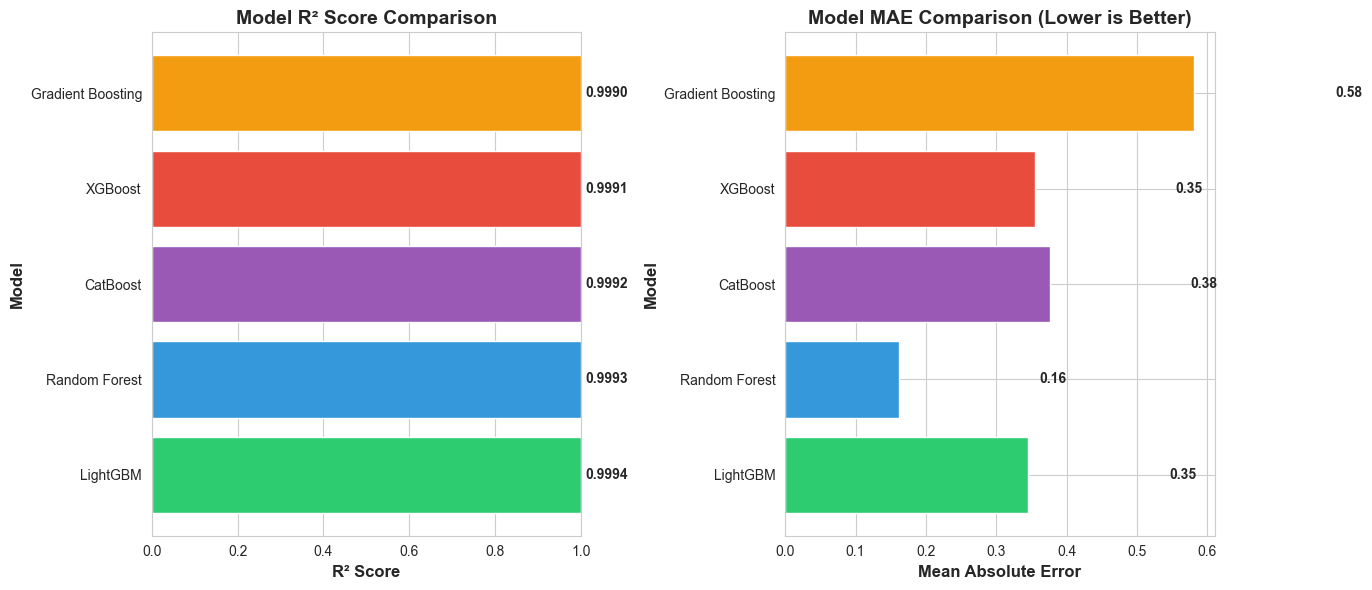


✓ Best Model: LightGBM (R² = 0.9994)


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot 1: R² Score Comparison
plt.subplot(1, 2, 1)
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
bars = plt.barh(model_comparison['Model'], model_comparison['R² Score'], color=colors)
plt.xlabel('R² Score', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.title('Model R² Score Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)

# Add value labels on bars
for i, (model, score) in enumerate(zip(model_comparison['Model'], model_comparison['R² Score'])):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center', fontweight='bold')

# Plot 2: MAE Comparison
plt.subplot(1, 2, 2)
bars = plt.barh(model_comparison['Model'], model_comparison['MAE'], color=colors)
plt.xlabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.title('Model MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (model, mae) in enumerate(zip(model_comparison['Model'], model_comparison['MAE'])):
    plt.text(mae + 0.2, i, f'{mae:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Best Model: {model_comparison.iloc[0]['Model']} (R² = {model_comparison.iloc[0]['R² Score']:.4f})")

## 4.8 Hyperparameter Tuning of best three models using Bayesian Optimization

### 4.8.1 LightGBM Hyperparameter Tuning

In [123]:

# lgb_param_dist = {
#     'n_estimators': (1500, 3500),
#         'learning_rate': (0.005, 0.15),
#         'max_depth': (3, 15),
#         'num_leaves': (20, 200),
#         'min_child_samples': (5, 100),
#         'subsample': (0.5, 1.0),
#         'colsample_bytree': (0.5, 1.0),
#         'reg_alpha': (1e-9, 10.0),
#         'reg_lambda': (1e-9, 10.0),
#         'min_split_gain': (0.0, 1.0),
#         'min_child_weight': (1e-5, 1e2),
#         'random_state': 42,
#         'verbose': -1,
#         'n_jobs': -1
# }

# lgb_random_search = RandomizedSearchCV(
#     lgb.LGBMRegressor(random_state=42, verbose=-1),
#     param_distributions=lgb_param_dist,
#     n_iter=100,
#     cv=3,
#     scoring='r2',
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )

# lgb_random_search.fit(X_train, y_train)
# print("LightGBM Best Params:", lgb_random_search.best_params_)
# print("LightGBM Best R² Score:", lgb_random_search.best_score_)

### 4.8.2 XGBoost Hyperparameter Tuning

In [124]:
# xgb_param_dist = {
#         'n_estimators': ( 1500, 3000),
#         'learning_rate': ( 0.005, 0.15),
#         'max_depth': ( 3, 15),
#         'min_child_weight': ( 1, 15),
#         'subsample': (0.5, 1.0),
#         'colsample_bytree':( 0.5, 1.0),
#         'colsample_bylevel': ( 0.5, 1.0),
#         'colsample_bynode': ( 0.5, 1.0),
#         'gamma': ( 1e-9, 5.0),
#         'reg_alpha': ( 1e-9, 10.0),
#         'reg_lambda': (1e-9, 10.0),
#         'max_delta_step': (0, 10),
#         'random_state': 42,
#         'tree_method': 'hist',
#         'n_jobs': -1
# }

# xgb_random_search = RandomizedSearchCV(
#     xgb.XGBRegressor(random_state=42, verbosity=0),
#     param_distributions=xgb_param_dist,
#     n_iter=100,
#     cv=3,
#     scoring='r2',
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )

# xgb_random_search.fit(X_train, y_train)
# print("XGBoost Best Params:", xgb_random_search.best_params_)
# print("XGBoost Best R² Score:", xgb_random_search.best_score_)

### 4.8.3 CatBoost Hyperparameter Tuning

In [125]:
# cat_param_dist = {
#     'iterations': randint(1000, 3000),
#     'learning_rate': uniform(0.01, 0.09),
#     'depth': randint(4, 10),
#     'l2_leaf_reg': uniform(1.0, 9.0),
#     'border_count': randint(32, 255),
#     'random_strength': uniform(1.0, 9.0),
#     'bagging_temperature': uniform(0.0, 1.0),
# }

# cat_random_search = RandomizedSearchCV(
#     CatBoostRegressor(random_state=42, verbose=0),
#     param_distributions=cat_param_dist,
#     n_iter=100,
#     cv=3,
#     scoring='r2',
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )

# cat_random_search.fit(X_train, y_train)
# print("CatBoost Best Params:", cat_random_search.best_params_)
# print("CatBoost Best R² Score:", cat_random_search.best_score_)

# 5. Feature Engineering of Test Data

## 5.1 Feature Engineering

In [126]:
# Prepare test data
test = sample_submission.copy()
test['book_theater_id'] = test['ID'].apply(lambda x: "_".join(x.split('_')[:2]))
test['show_date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[-1]))

In [127]:
# Add theater statistics
test = test.merge(theater_performance, left_on='book_theater_id', right_index=True, how='left')
test['avg_audience'].fillna(test['avg_audience'].mean(), inplace=True)
test['min_audience'].fillna(test['min_audience'].mean(), inplace=True)
test['max_audience'].fillna(test['max_audience'].mean(), inplace=True)
test['std_audience'].fillna(test['std_audience'].mean(), inplace=True)

In [128]:
# Temporal features
test['year'] = test['show_date'].dt.year
test['month'] = test['show_date'].dt.month
test['day'] = test['show_date'].dt.day
test['day_of_week'] = test['show_date'].dt.day_of_week
test['weekofyear'] = test['show_date'].dt.isocalendar().week
test['day_of_year'] = test['show_date'].dt.dayofyear
test['quarter'] = test['show_date'].dt.quarter
test['day_of_quarter'] = test['show_date'].apply(
    lambda x: (x - pd.Timestamp(x.year, (x.quarter-1)*3 + 1, 1)).days + 1
)
test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)
test['is_month_start'] = test['show_date'].dt.is_month_start.astype(int)
test['is_month_end'] = test['show_date'].dt.is_month_end.astype(int)
test['is_quarter_start'] = test['show_date'].dt.is_quarter_start.astype(int)
test['is_quarter_end'] = test['show_date'].dt.is_quarter_end.astype(int)

In [129]:
# Interaction features
test['theater_x_month'] = test['book_theater_id'].astype(str) + '_' + test['month'].astype(str)
test['theater_x_dow'] = test['book_theater_id'].astype(str) + '_' + test['day_of_week'].astype(str)
test['month_x_dow'] = test['month'].astype(str) + '_' + test['day_of_week'].astype(str)

In [130]:
test.columns

Index(['ID', 'audience_count', 'book_theater_id', 'show_date', 'avg_audience',
       'min_audience', 'max_audience', 'std_audience', 'total_shows', 'year',
       'month', 'day', 'day_of_week', 'weekofyear', 'day_of_year', 'quarter',
       'day_of_quarter', 'is_weekend', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'theater_x_month',
       'theater_x_dow', 'month_x_dow'],
      dtype='object')

## 5.2 Creating Rolling Features in test data

In [131]:
combined = pd.concat([
    booknow_visits[['book_theater_id', 'show_date', 'audience_count']],
    test[['book_theater_id', 'show_date']].assign(audience_count=np.nan)
], ignore_index=True).sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

In [132]:
for lag in [1, 2, 3, 7, 14, 21, 28]:
    combined[f'lag_{lag}'] = combined.groupby('book_theater_id')['audience_count'].shift(lag)

In [133]:
for window in [3, 7, 14, 21, 28]:
    combined[f'rolling_mean_{window}'] = combined.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())
    combined[f'rolling_std_{window}'] = combined.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std())
    combined[f'rolling_min_{window}'] = combined.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(window=window, min_periods=1).min())
    combined[f'rolling_max_{window}'] = combined.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max())

In [134]:
for span in [3, 7, 14]:
    combined[f'ewm_{span}'] = combined.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.ewm(span=span, min_periods=1).mean())

In [135]:
test_with_lags = combined[combined['audience_count'].isna()].drop(columns=['audience_count'])
test = test.merge(test_with_lags, on=['book_theater_id', 'show_date'], how='left')

In [136]:
theater_mapping = dict(zip(le_theater.classes_, le_theater.transform(le_theater.classes_)))
test['book_theater_id_encoded'] = test['book_theater_id'].map(theater_mapping).fillna(-1).astype(int)

In [137]:
theater_month_mapping = dict(zip(le_theater_month.classes_, le_theater_month.transform(le_theater_month.classes_)))
test['theater_x_month_encoded'] = test['theater_x_month'].map(theater_month_mapping).fillna(-1).astype(int)

In [138]:
theater_dow_mapping = dict(zip(le_theater_dow.classes_, le_theater_dow.transform(le_theater_dow.classes_)))
test['theater_x_dow_encoded'] = test['theater_x_dow'].map(theater_dow_mapping).fillna(-1).astype(int)

In [139]:
month_dow_mapping = dict(zip(le_month_dow.classes_, le_month_dow.transform(le_month_dow.classes_)))
test['month_x_dow_encoded'] = test['month_x_dow'].map(month_dow_mapping).fillna(-1).astype(int)

In [140]:
test['days_from_avg'] = 0
test['pct_of_avg'] = 1

In [141]:
test_features = test[feature_cols]

In [142]:
for col in test_features.columns:
    if test_features[col].isnull().sum() > 0:
        median_val = X_train[col].median() if col in X_train.columns else 0
        test_features[col].fillna(median_val, inplace=True)

In [143]:
test_features.shape

(38062, 53)

# 6. Making prediction using Ensemble Model

## 6.1 Finding Optimal Ensemble Weights

In [144]:
# Get validation predictions from the 3 models (LightGBM, Random Forest, CatBoost)
val_pred_lgb = lgb_model.predict(X_val)
val_pred_rf = rf_model.predict(X_val)
val_pred_cat = cat_model.predict(X_val)

# Stack predictions (only 3 models)
val_predictions = np.column_stack([
    val_pred_lgb,
    val_pred_rf,
    val_pred_cat
])

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 338 out of 338 | elapsed:    0.1s finished


In [145]:
# Define objective function to minimize (negative R² or MSE)
def ensemble_objective(weights, predictions, y_true):
    weights = weights / np.sum(weights)
    ensemble_pred = np.dot(predictions, weights)
    r2 = r2_score(y_true, ensemble_pred)
    
    return -r2

initial_weights = np.array([0.33, 0.33, 0.34])
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1) for _ in range(3)]

result = minimize(
    ensemble_objective,
    initial_weights,
    args=(val_predictions, y_val),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-9}
)

optimal_weights = result.x / np.sum(result.x)

print("OPTIMAL ENSEMBLE WEIGHTS:")
print(f"LightGBM:         {optimal_weights[0]:.4f} ({optimal_weights[0]*100:.2f}%)")
print(f"Random Forest:    {optimal_weights[1]:.4f} ({optimal_weights[1]*100:.2f}%)")
print(f"CatBoost:         {optimal_weights[2]:.4f} ({optimal_weights[2]*100:.2f}%)")

OPTIMAL ENSEMBLE WEIGHTS:
LightGBM:         0.2410 (24.10%)
Random Forest:    0.4188 (41.88%)
CatBoost:         0.3402 (34.02%)


In [146]:
# Calculate performance with optimal weights
optimal_ensemble_pred = np.dot(val_predictions, optimal_weights)
optimal_r2 = r2_score(y_val, optimal_ensemble_pred)
optimal_mae = mean_absolute_error(y_val, optimal_ensemble_pred)

## 6.2 Generate Predictions

In [147]:
# Generate predictions from the 3 models (LightGBM, Random Forest, CatBoost)
pred_lgb = lgb_model.predict(test_features)
pred_rf = rf_model.predict(test_features)
pred_cat = cat_model.predict(test_features)

# Stack predictions
test_predictions = np.column_stack([pred_lgb, pred_rf, pred_cat])

# Use optimal weights for ensemble
predictions = np.dot(test_predictions, optimal_weights)
predictions = np.maximum(predictions, 0)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 338 out of 338 | elapsed:    0.0s finished


In [148]:
submission = pd.DataFrame({
    'ID': sample_submission['ID'],
    'audience_count': predictions
})

submission.to_csv('submission.csv', index=False)